In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from scipy.integrate import odeint

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

from prophet import Prophet

In [2]:
# Loading Excel file 
file_path = "C:/Users/Shubham/Downloads/Copy of Resistance_Campylo isolates.xlsx"
export_df = pd.read_excel(file_path, sheet_name='Export')  # Adjust sheet name if needed
metadata_df = pd.read_excel(file_path, sheet_name='metadata')  # Adjust sheet name if needed

# Standardiing column names 
export_df.columns = export_df.columns.str.strip().str.lower()
metadata_df.columns = metadata_df.columns.str.strip().str.lower()

# Printing out the columns to check for any discrepancies
print("Columns in Export Dataset:")
print(export_df.columns)

print("\nColumns in Metadata Dataset:")
print(metadata_df.columns)


if export_df['species'].isnull().any():
    print("There are missing values in 'species' column in Export Dataset.")
    export_df = export_df.dropna(subset=['species'])  # Drop rows with missing 'species'

if metadata_df['species'].isnull().any():
    print("There are missing values in 'species' column in Metadata Dataset.")
    metadata_df = metadata_df.dropna(subset=['species'])  # Drop rows with missing 'species'

# Double-check for any leading/trailing spaces in the 'species' column
export_df['species'] = export_df['species'].str.strip()
metadata_df['species'] = metadata_df['species'].str.strip()

# Merging datasets and inspecting columns
data = pd.merge(
    export_df,
    metadata_df,
    on=['id', 'region', 'year', 'month', 'isolation_date', 'species', 'source'],
    how='inner'
)

# Checking columns to identify potential duplicates or renames
print("Columns in Merged Dataset:")
print(data.columns)


if 'age_yr_x' in data.columns:
    data.rename(columns={'age_yr_x': 'age_yr', 'age_mth_x': 'age_mth'}, inplace=True)

# Cleaning and feature engineering

if 'age_yr' in data.columns:
    data['age_yr'] = data['age_yr'].fillna(data['age_yr'].median())  # Fill missing age with median
else:
    print("Column 'age_yr' not found in the dataset.")

if 'sex' in data.columns:
    data['sex'] = data['sex'].fillna('unknown')  # Replace missing sex with 'unknown'
else:
    print("Column 'sex' not found in the dataset.")


categorical_columns = ['region', 'sex', 'source', 'species']
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col, encoder in label_encoders.items():
    if col in data.columns:
        data[col] = encoder.fit_transform(data[col])
    else:
        print(f"Column '{col}' not found in the dataset.")


data['cattle_consumption_kg_per_year'] = 35

# Feature engineering: creating age groups
if 'age_yr' in data.columns:
    bins = [0, 18, 45, 65, 100]
    labels = ['child', 'adult', 'middle_age', 'elderly']
    data['age_group'] = pd.cut(data['age_yr'], bins=bins, labels=labels)
else:
    print("Cannot create age groups as 'age_yr' is missing.")

# Check the cleaned data
print("\nCleaned and Preprocessed Data:")
print(data.head())

# Save cleaned dataset for further use
data.to_excel('Cleaned_Data.xlsx', index=False)


C:\Users\Shubham\AppData\Local\Temp\ipykernel_20368\3034294520.py:3: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  export_df = pd.read_excel(file_path, sheet_name='Export')  # Adjust sheet name if needed
C:\Users\Shubham\AppData\Local\Temp\ipykernel_20368\3034294520.py:4: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  metadata_df = pd.read_excel(file_path, sheet_name='metadata')  # Adjust sheet name if needed


Columns in Export Dataset:
Index(['id', 'old isolate code', 'new isolate code', 'sanger code', 'region',
       'year', 'month', 'isolation_date', 'age_yr', 'age_mth', 'sex', 'source',
       'species', 'aspa', 'glna', 'glta', 'glya', 'pgm', 'tkt', 'unca',
       'st (mlst)', 'clonal_complex (mlst)', 'camp0950 (gyra)', 'c257t',
       't86i', 'a256g', 't86a', 'g268a', 'd90n', 'g268t', 'd90y', 'c310a',
       'p104t', 'c310t', 'p104s', 'gyra mutation', 'fq res', 'camp1698 (tet)',
       'gene', 'a2074', 'a2075', 'mac res', 'oxa enzyme', 'nuc -57',
       'camp0262', 'camp0263', 'camp0264', 'camp0265', 'camp0266', 'camp0267'],
      dtype='object')

Columns in Metadata Dataset:
Index(['id', 'isolate', 'region', 'year', 'month', 'isolation_date', 'age_yr',
       'age_mth', 'sex', 'source', 'species', 'enaaccession'],
      dtype='object')
There are missing values in 'species' column in Metadata Dataset.
Columns in Merged Dataset:
Index(['id', 'old isolate code', 'new isolate code', 'sang

In [3]:
# Standardizing species column by removing spaces in both datasets
export_df['species'] = export_df['species'].str.replace(" ", "")
metadata_df['species'] = metadata_df['species'].str.replace(" ", "")

# Reattempt the merge after standardization
merged_data = pd.merge(export_df, metadata_df, on=['id', 'region', 'year', 'month', 'isolation_date', 'species', 'source'], how='inner')
print(merged_data.head())


# Drop rows with missing critical columns in both datasets
export_df_clean = export_df.dropna(subset=['id', 'region', 'year', 'month', 'isolation_date', 'species', 'source'])
metadata_df_clean = metadata_df.dropna(subset=['id', 'region', 'year', 'month', 'isolation_date', 'species', 'source'])


merged_data_clean = pd.merge(export_df_clean, metadata_df_clean, on=['id', 'region', 'year', 'month', 'isolation_date', 'species', 'source'], how='inner')
print(merged_data_clean.head())


# Split the data into smaller chunks by year or region
export_df_chunked = export_df.groupby('year')  # or 'region'

# Merging chunks one by one to manage memory usage
for year, chunk in export_df_chunked:
    merged_chunk = pd.merge(chunk, metadata_df_clean, on=['id', 'region', 'year', 'month', 'isolation_date', 'species', 'source'], how='inner')
    # Optionally, save each merged chunk to a file or append to a master DataFrame
    print(f"Merged data for year {year}:")
    print(merged_chunk.head())


      id old isolate code new isolate code sanger code    region    year  \
0  28815            B0200            B0200  12227_1_60  Aberdeen  2013.0   
1  28816            B0220            B0220  12448_3_78  Aberdeen  2013.0   
2  28817            B0241            B0241   12448_4_2  Aberdeen  2013.0   
3  28818            B0268            B0268  12448_4_93  Aberdeen  2014.0   
4  28821            C0840            C0840  12448_3#67  Aberdeen  2014.0   

   month isolation_date  age_yr_x  age_mth_x  ... camp0263 camp0264 camp0265  \
0   10.0     2013-10-22       NaN        NaN  ...        1       12        1   
1   11.0     2013-11-12       NaN        NaN  ...        1       12        1   
2   12.0     2013-12-10       NaN        NaN  ...        1       12        1   
3    1.0     2014-01-28       NaN        NaN  ...      NaN      NaN      NaN   
4    1.0     2014-01-14       NaN        NaN  ...        1        1      NaN   

   camp0266  camp0267  isolate  age_yr_y  age_mth_y  sex_y  en

Merged data for year 2012.0:
      id old isolate code new isolate code      sanger code    region    year  \
0  39807            C0464            C0464       11822_6#52  Aberdeen  2012.0   
1  39808            C0465            C0465       11822_6#53  Aberdeen  2012.0   
2  39809            C0467            C0467       11822_6#54  Aberdeen  2012.0   
3  39810            C0469            C0469       11822_6#16  Aberdeen  2012.0   
4  42645            C_369            C0369  8337_4#93_A9705  Aberdeen  2012.0   

   month isolation_date  age_yr_x  age_mth_x  ... camp0263 camp0264 camp0265  \
0   12.0     2012-12-01       NaN        NaN  ...        1        1        1   
1   12.0     2012-12-01       NaN        NaN  ...        1        1        1   
2   12.0     2012-12-01       NaN        NaN  ...        1        1        1   
3   12.0     2012-12-01       NaN        NaN  ...       46        1        1   
4    1.0     2012-01-10       NaN        NaN  ...       56       19        1   

   

In [4]:
# Check for unique values in the merge keys for each dataset
print("Export Dataset - Unique Values in Merge Keys:")
print(export_df[['id', 'region', 'year', 'month', 'isolation_date', 'species', 'source']].drop_duplicates())

print("\nMetadata Dataset - Unique Values in Merge Keys:")
print(metadata_df[['id', 'region', 'year', 'month', 'isolation_date', 'species', 'source']].drop_duplicates())

# Compare overlap in 'id' as a critical key
common_ids = set(export_df['id']).intersection(set(metadata_df['id']))
print(f"\nNumber of Common IDs: {len(common_ids)}")

Export Dataset - Unique Values in Merge Keys:
         id    region    year  month isolation_date              species  \
0      3656  Aberdeen  2006.0    6.0     2006-06-15  Campylobacterjejuni   
1     28815  Aberdeen  2013.0   10.0     2013-10-22  Campylobacterjejuni   
2     28816  Aberdeen  2013.0   11.0     2013-11-12  Campylobacterjejuni   
3     28817  Aberdeen  2013.0   12.0     2013-12-10  Campylobacterjejuni   
4     28818  Aberdeen  2014.0    1.0     2014-01-28  Campylobacterjejuni   
...     ...       ...     ...    ...            ...                  ...   
6678  64033  Aberdeen  2011.0    2.0     2011-02-01  Campylobacterjejuni   
6679  64034  Aberdeen     NaN    NaN            NaT  Campylobacterjejuni   
6680  64035  Aberdeen     NaN    NaN            NaT  Campylobacterjejuni   
6681  64038  Aberdeen     NaN    NaN            NaT  Campylobacterjejuni   
6682  64039  Aberdeen     NaN    NaN            NaT  Campylobacterjejuni   

           source  
0     human stool  
1

In [5]:
# Standardize 'species' column
export_df['species'] = export_df['species'].str.replace(" ", "").str.lower()
metadata_df['species'] = metadata_df['species'].str.replace(" ", "").str.lower()

# Standardize 'source' column
export_df['source'] = export_df['source'].str.replace(" ", "").str.lower()
metadata_df['source'] = metadata_df['source'].str.replace(" ", "").str.lower()

# Merge datasets using 'id' and standardize values
merged_df = pd.merge(
    export_df,
    metadata_df,
    on='id',
    how='inner',
    suffixes=('_export', '_meta')
)
print(f"Number of Rows in Merged Dataset: {len(merged_df)}")

# Resolve conflicts in 'species' and 'source'
merged_df['species'] = merged_df['species_export'].combine_first(merged_df['species_meta'])
merged_df['source'] = merged_df['source_export'].combine_first(merged_df['source_meta'])

# Drop redundant columns
merged_df.drop(columns=['species_export', 'species_meta', 'source_export', 'source_meta'], inplace=True)

# Preview and save the cleaned merged dataset
print(merged_df.head())
merged_df.to_excel("Cleaned_Merged_Dataset.xlsx", index=False)

Number of Rows in Merged Dataset: 6683
      id old isolate code new isolate code sanger code region_export  \
0   3656             3894             3894  19109_2#54      Aberdeen   
1  28815            B0200            B0200  12227_1_60      Aberdeen   
2  28816            B0220            B0220  12448_3_78      Aberdeen   
3  28817            B0241            B0241   12448_4_2      Aberdeen   
4  28818            B0268            B0268  12448_4_93      Aberdeen   

   year_export  month_export isolation_date_export  age_yr_export  \
0       2006.0           6.0            2006-06-15           43.0   
1       2013.0          10.0            2013-10-22            NaN   
2       2013.0          11.0            2013-11-12            NaN   
3       2013.0          12.0            2013-12-10            NaN   
4       2014.0           1.0            2014-01-28            NaN   

   age_mth_export  ... region_meta  year_meta  month_meta  \
0             NaN  ...    Aberdeen     2006.0       

In [6]:
# Check the columns in merged_df to confirm the presence of 'species' with or without suffix
print("Columns in Merged DataFrame:")
print(merged_df.columns)

# If 'species_export' or 'species_metadata' is found, handle it accordingly
if 'species_export' in merged_df.columns:
    merged_df['species'] = merged_df['species_export'].fillna('Unknown')
elif 'species_metadata' in merged_df.columns:
    merged_df['species'] = merged_df['species_metadata'].fillna('Unknown')
else:
    print("Column 'species' not found in the merged data.")


Columns in Merged DataFrame:
Index(['id', 'old isolate code', 'new isolate code', 'sanger code',
       'region_export', 'year_export', 'month_export', 'isolation_date_export',
       'age_yr_export', 'age_mth_export', 'sex_export', 'aspa', 'glna', 'glta',
       'glya', 'pgm', 'tkt', 'unca', 'st (mlst)', 'clonal_complex (mlst)',
       'camp0950 (gyra)', 'c257t', 't86i', 'a256g', 't86a', 'g268a', 'd90n',
       'g268t', 'd90y', 'c310a', 'p104t', 'c310t', 'p104s', 'gyra mutation',
       'fq res', 'camp1698 (tet)', 'gene', 'a2074', 'a2075', 'mac res',
       'oxa enzyme', 'nuc -57', 'camp0262', 'camp0263', 'camp0264', 'camp0265',
       'camp0266', 'camp0267', 'isolate', 'region_meta', 'year_meta',
       'month_meta', 'isolation_date_meta', 'age_yr_meta', 'age_mth_meta',
       'sex_meta', 'enaaccession', 'species', 'source'],
      dtype='object')
Column 'species' not found in the merged data.


In [7]:



export_file_path = 'export_data.csv'
metadata_file_path = 'metadata_data.csv'

# Load the datasets
export_df = pd.read_excel(file_path, sheet_name='Export')  # Adjust sheet name if needed
metadata_df = pd.read_excel(file_path, sheet_name='metadata')  # Adjust sheet name if needed

# Merge datasets on the 'id' column
merged_df = pd.merge(export_df, metadata_df, on='id', how='inner', suffixes=('_export', '_metadata'))

# Renaming columns to remove the '_x' and '_y' suffixes and keep the most relevant columns
merged_df.rename(columns={
    'region_export': 'region',
    'year_export': 'year',
    'month_export': 'month',
    'isolation_date_export': 'isolation_date',
    'age_yr_export': 'age_yr',
    'age_mth_export': 'age_mth',
    'sex_export': 'sex',
    'source_export': 'source',
    'species_export': 'species',
    'region_metadata': 'region_metadata',
    'year_metadata': 'year_metadata',
    'month_metadata': 'month_metadata',
    'isolation_date_metadata': 'isolation_date_metadata',
    'age_yr_metadata': 'age_yr_metadata',
    'age_mth_metadata': 'age_mth_metadata',
    'sex_metadata': 'sex_metadata',
    'source_metadata': 'source_metadata',
    'species_metadata': 'species_metadata',
    'ENAaccession': 'ena_accession'
}, inplace=True)


merged_df['species'] = merged_df['species'].fillna('Unknown')


merged_df['age_group'] = pd.cut(merged_df['age_yr'], bins=[0, 18, 35, 50, 65, 100], 
                                labels=['0-18', '19-35', '36-50', '51-65', '66+'], right=False)


print("Cleaned and Preprocessed Data:\n", merged_df.head(), "\n")

# Export the cleaned data to a new CSV
output_file_path = 'cleaned_merged_data.csv'
merged_df.to_csv(output_file_path, index=False)

# Print confirmation
print(f"Cleaned data saved to {output_file_path}")


C:\Users\Shubham\AppData\Local\Temp\ipykernel_20368\2621600277.py:5: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  export_df = pd.read_excel(file_path, sheet_name='Export')  # Adjust sheet name if needed
C:\Users\Shubham\AppData\Local\Temp\ipykernel_20368\2621600277.py:6: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  metadata_df = pd.read_excel(file_path, sheet_name='metadata')  # Adjust sheet name if needed


Cleaned and Preprocessed Data:
       id old isolate code new isolate code Sanger code    region    year  \
0   3656             3894             3894  19109_2#54  Aberdeen  2006.0   
1  28815            B0200            B0200  12227_1_60  Aberdeen  2013.0   
2  28816            B0220            B0220  12448_3_78  Aberdeen  2013.0   
3  28817            B0241            B0241   12448_4_2  Aberdeen  2013.0   
4  28818            B0268            B0268  12448_4_93  Aberdeen  2014.0   

   month isolation_date  age_yr  age_mth  ... year_metadata month_metadata  \
0    6.0     2006-06-15    43.0      NaN  ...        2006.0            6.0   
1   10.0     2013-10-22     NaN      NaN  ...        2013.0           10.0   
2   11.0     2013-11-12     NaN      NaN  ...        2013.0           11.0   
3   12.0     2013-12-10     NaN      NaN  ...        2013.0           12.0   
4    1.0     2014-01-28     NaN      NaN  ...        2014.0            1.0   

  isolation_date_metadata  age_yr_metadata

In [8]:

summary_stats = merged_df.describe()

print("Summary Statistics:\n", summary_stats)


Summary Statistics:
                  id         year        month       age_yr    age_mth  \
count   6683.000000  5788.000000  6443.000000  4001.000000  16.000000   
mean   45933.572348  1888.705252   117.893838    41.725819   7.812500   
std     8468.191003   482.825797   459.084432    22.005421   2.257395   
min     3656.000000     1.000000     1.000000     0.000000   3.000000   
25%    40189.500000  2012.000000     4.000000    24.000000   7.000000   
50%    42037.000000  2013.000000     7.000000    43.000000   8.500000   
75%    56216.500000  2015.000000    10.000000    59.000000   9.000000   
max    64039.000000  2017.000000  2011.000000    94.000000  11.000000   

              aspA         glnA         gltA         glyA          pgm  \
count  6683.000000  6683.000000  6683.000000  6682.000000  6683.000000   
mean     12.201556    15.523118    11.340416    26.283598    31.873859   
std      27.507147    41.205650    23.905351    58.133030    77.868803   
min       1.000000     1.

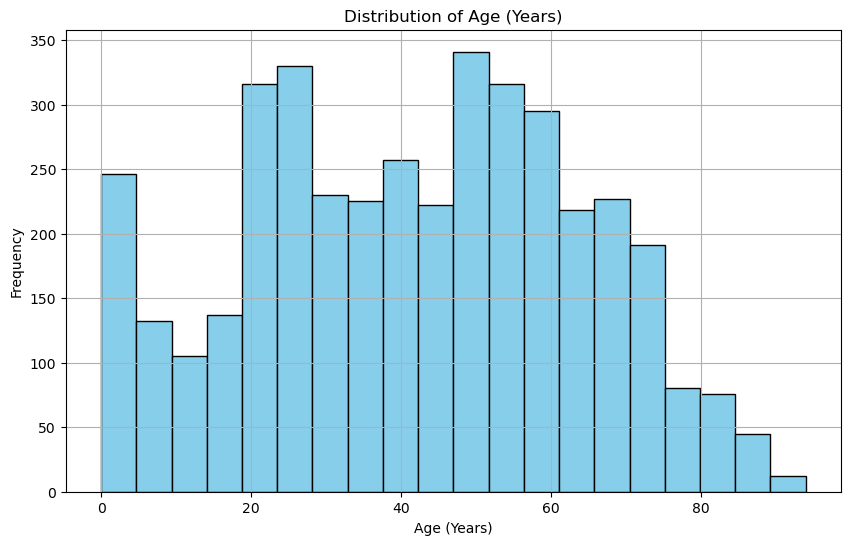

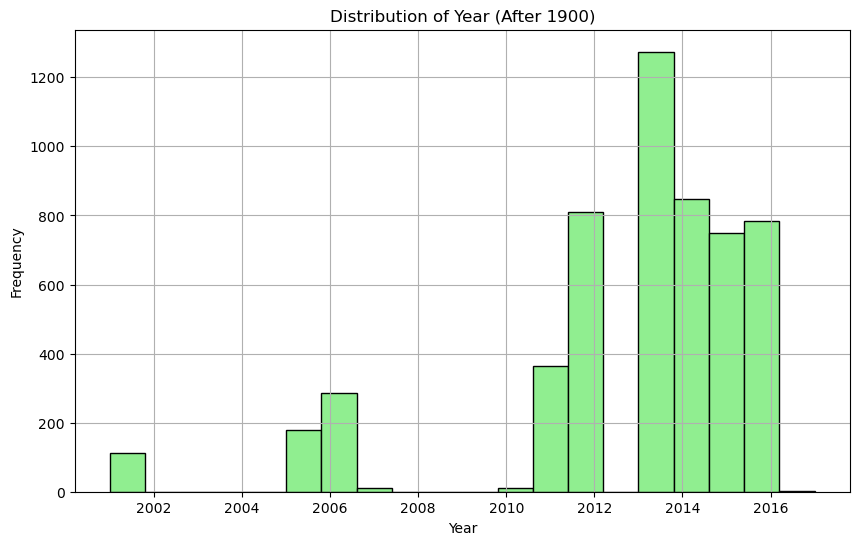

In [9]:


# Plot histogram for 'age_yr'
plt.figure(figsize=(10, 6))
merged_df['age_yr'].dropna().hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Age (Years)')
plt.xlabel('Age (Years)')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'year'
plt.figure(figsize=(10, 6))
merged_df[merged_df['year'] > 1900]['year'].dropna().hist(bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Year (After 1900)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()


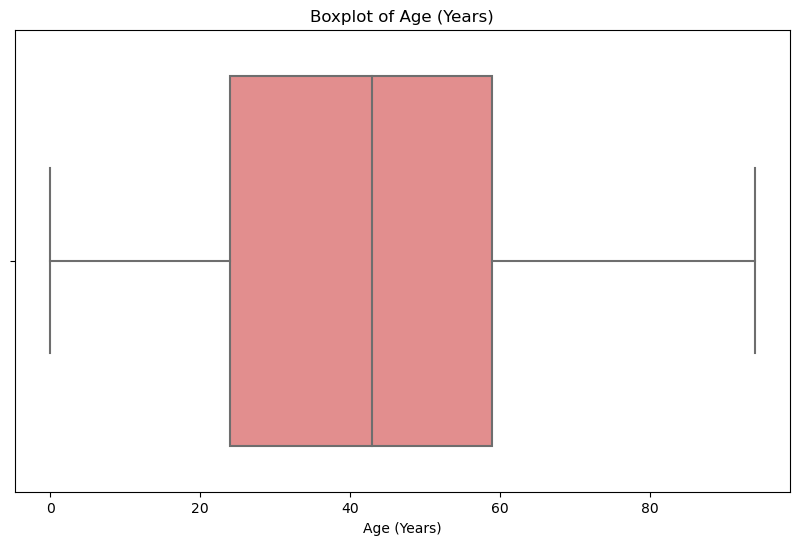

In [10]:


# Boxplot for 'age_yr'
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['age_yr'].dropna(), color='lightcoral')
plt.title('Boxplot of Age (Years)')
plt.xlabel('Age (Years)')
plt.show()


<Figure size 1200x600 with 0 Axes>

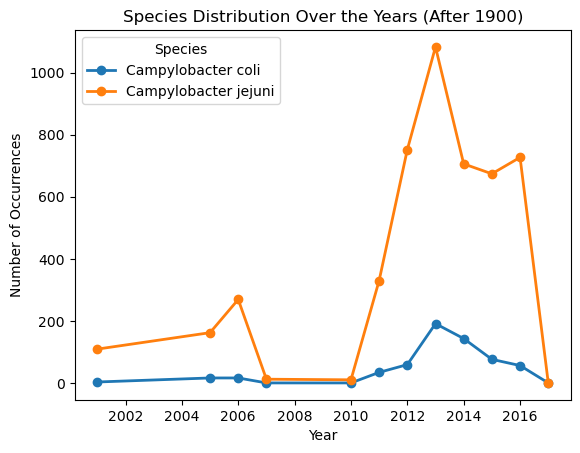

In [11]:
# Count of 'species' by year (filtering years after 1900)
species_by_year = (
    merged_df[merged_df['year'] > 1900]
    .groupby(['year', 'species'])
    .size()
    .unstack()
    .fillna(0)
)

# Plot time series of species over the years
plt.figure(figsize=(12, 6))
species_by_year.plot(kind='line', marker='o', linewidth=2)
plt.title('Species Distribution Over the Years (After 1900)')
plt.xlabel('Year')
plt.ylabel('Number of Occurrences')
plt.legend(title='Species')
plt.show()


In [12]:
# Group by 'species' and get mean age ('age_yr')
species_age = merged_df.groupby('species')['age_yr'].mean()

print("Average Age by Species:\n", species_age)

# Group by 'region' and get the count of records
region_counts = merged_df['region'].value_counts()

print("Number of Records by Region:\n", region_counts)


Average Age by Species:
 species
Campylobacter coli      44.151786
Campylobacter jejuni    41.503411
Name: age_yr, dtype: float64
Number of Records by Region:
 Aberdeen    6492
Scotland       1
Name: region, dtype: int64


In [13]:
# Get summary statistics for numerical columns
summary_stats = merged_df.describe()

print("Summary Statistics:\n", summary_stats)


Summary Statistics:
                  id         year        month       age_yr    age_mth  \
count   6683.000000  5788.000000  6443.000000  4001.000000  16.000000   
mean   45933.572348  1888.705252   117.893838    41.725819   7.812500   
std     8468.191003   482.825797   459.084432    22.005421   2.257395   
min     3656.000000     1.000000     1.000000     0.000000   3.000000   
25%    40189.500000  2012.000000     4.000000    24.000000   7.000000   
50%    42037.000000  2013.000000     7.000000    43.000000   8.500000   
75%    56216.500000  2015.000000    10.000000    59.000000   9.000000   
max    64039.000000  2017.000000  2011.000000    94.000000  11.000000   

              aspA         glnA         gltA         glyA          pgm  \
count  6683.000000  6683.000000  6683.000000  6682.000000  6683.000000   
mean     12.201556    15.523118    11.340416    26.283598    31.873859   
std      27.507147    41.205650    23.905351    58.133030    77.868803   
min       1.000000     1.

In [14]:


class EnhancedAMRAnalysis:
    def __init__(self):
        pass
        
    def analyze_temporal_patterns(self, df):
        """Analyze temporal patterns in resistance """
        temporal_analysis = df[df['year_export'] > 1900].groupby('year_export').agg({
            'fq res': lambda x: (x == 'R').mean() * 100,
            'mac res': lambda x: (x == 'R').mean() * 100,
            'gyra mutation': lambda x: (x != 'no mutation').mean() * 100
        }).reset_index()
        
        plt.figure(figsize=(12, 6))
        plt.plot(temporal_analysis['year_export'], temporal_analysis['fq res'], 
                 label='Fluoroquinolone Resistance')
        plt.plot(temporal_analysis['year_export'], temporal_analysis['mac res'], 
                 label='Macrolide Resistance')
        plt.plot(temporal_analysis['year_export'], temporal_analysis['gyra mutation'], 
                 label='gyrA Mutations')
        plt.title('Temporal Trends in Resistance Rates (Years > 1900)')
        plt.xlabel('Year')
        plt.ylabel('Resistance Rate (%)')
        plt.legend()
        plt.grid(True)
        return plt

    def analyze_mutation_patterns(self, df):
        """Analyze mutation patterns and their impact"""
        mutation_analysis = pd.DataFrame({
            'Mutation Type': ['T86I Mutation', 'OXA Enzyme Present', 'Other gyrA Mutations'],
            'Resistance Rate': [
                df[df['t86i'] == 'T86I']['fq res'].eq('R').mean() * 100,
                df[df['oxa enzyme'].notna()]['fq res'].eq('R').mean() * 100,
                df[df['gyra mutation'] != 'no mutation']['fq res'].eq('R').mean() * 100
            ]
        })
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Mutation Type', y='Resistance Rate', data=mutation_analysis)
        plt.title('Impact of Different Mutations on Resistance')
        plt.ylabel('Resistance Rate (%)')
        plt.xticks(rotation=45)
        return plt

    def run_comprehensive_analysis(self, excel_path):
        """Run comprehensive AMR analysis"""
        print("Starting comprehensive AMR analysis...")
        
        try:
            # Load data
            df = pd.read_excel(excel_path)
            print(f"Loaded dataset with {len(df)} records")
            
            # Data validation
            required_columns = ['year_export', 'fq res', 'mac res', 'gyra mutation', 't86i', 'oxa enzyme', 'id']
            missing_columns = [col for col in required_columns if col not in df.columns]
            if missing_columns:
                raise ValueError(f"Missing required columns: {missing_columns}")
            
            # Run analyses
            temporal_plot = self.analyze_temporal_patterns(df)
            mutation_plot = self.analyze_mutation_patterns(df)
            
            # Generate summary statistics
            summary_stats = {
                'total_samples': len(df),
                'resistance_rate_fq': (df['fq res'] == 'R').mean() * 100,
                'resistance_rate_mac': (df['mac res'] == 'R').mean() * 100,
                'mutation_rate': (df['gyra mutation'] != 'no mutation').mean() * 100
            }
            
            return {
                'plots': {
                    'temporal': temporal_plot,
                    'mutation': mutation_plot
                },
                'summary_stats': summary_stats
            }
            
        except Exception as e:
            print(f"Error in analysis: {str(e)}")
            raise

def run_enhanced_analysis(excel_path):
    analyzer = EnhancedAMRAnalysis()
    results = analyzer.run_comprehensive_analysis(excel_path)
    
    # Print summary statistics
    print("\nSummary Statistics:")
    for key, value in results['summary_stats'].items():
        print(f"{key.replace('_', ' ').title()}: {value:.2f}")
    
    # Display plots
    for plot_name, plot in results['plots'].items():
        plot.show()
    
    return results


Starting comprehensive AMR analysis...
Loaded dataset with 6683 records

Summary Statistics:
Total Samples: 6683.00
Resistance Rate Fq: 21.17
Resistance Rate Mac: 0.88
Mutation Rate: 21.17


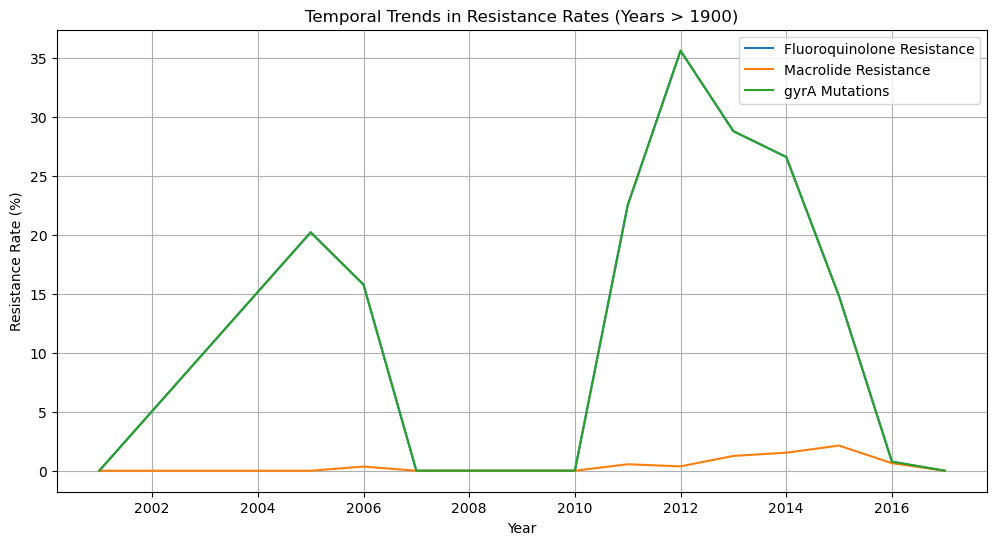

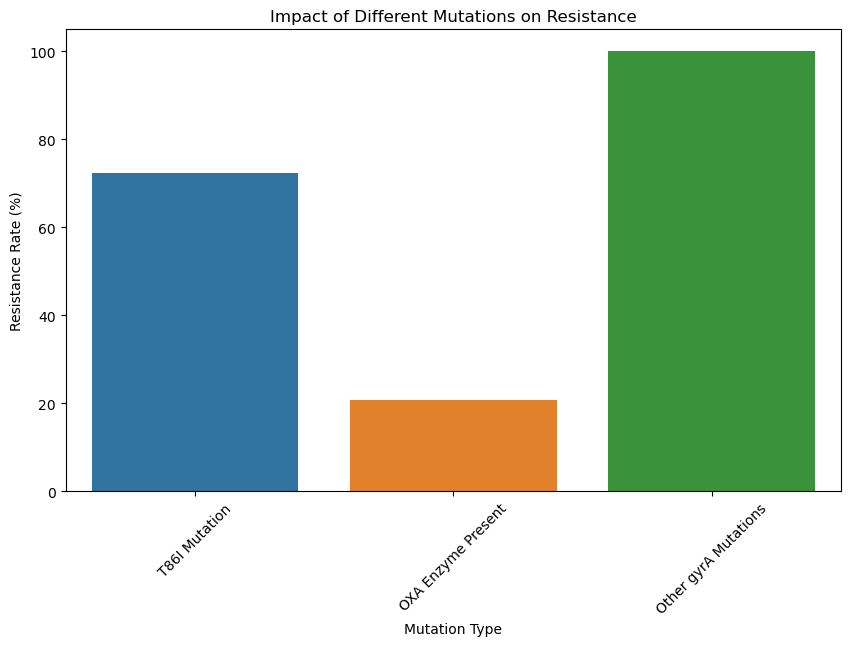

In [15]:
excel_file_path = r"C:\Users\Shubham\Downloads\Cleaned_Merged_Dataset.xlsx"
results = run_enhanced_analysis(excel_file_path)

In [16]:



class AMRCostBurdenAnalysis:
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        
    def load_data(self, excel_path):
        try:
            # Read the merged Excel file
            df = pd.read_excel(excel_path)
            print(f"Successfully loaded merged dataset:")
            print(f"Dataset shape: {df.shape}")
            print("\nColumns:", df.columns.tolist())
            return df
        except Exception as e:
            print(f"Error loading Excel file: {str(e)}")
            return None
    
    def preprocess_data(self, df):
        """Preprocess the merged dataset for analysis"""
        # Create resistance score based on multiple factors
        df['resistance_score'] = df.apply(
            lambda x: sum([
                1 if x['fq res'] == 'R' else 0,  # Fluoroquinolone resistance
                1 if x['mac res'] == 'R' else 0,  # Macrolide resistance
                1 if x['gyra mutation'] != 'no mutation' else 0,  # gyrA mutations
                1 if pd.notna(x['gene']) else 0  # Presence of resistance genes
            ]), axis=1
        )
        
        # Calculate temporal features
        df['year'] = pd.to_numeric(df['year_export'], errors='coerce')
        current_year = datetime.now().year
        df['years_since_isolation'] = current_year - df['year']
        
        # Encode categorical variables
        categorical_columns = ['source', 'species', 'sex_export', 'region_export']
        for col in categorical_columns:
            if col in df.columns:
                self.label_encoders[col] = LabelEncoder()
                df[col + '_encoded'] = self.label_encoders[col].fit_transform(
                    df[col].fillna('Unknown')
                )
        
        # Create mutation features
        df['t86i_mutation'] = df['t86i'].apply(lambda x: 1 if x == 'T86I' else 0)
        df['oxa_present'] = df['oxa enzyme'].apply(lambda x: 1 if pd.notna(x) and x != 'S' else 0)
        
        # Select features for modeling
        feature_columns = [
            'years_since_isolation',
            'source_encoded',
            'species_encoded',
            't86i_mutation',
            'oxa_present'
        ]
        
        # Add age if available
        if 'age_yr_export' in df.columns:
            df['age_yr_export'] = pd.to_numeric(df['age_yr_export'], errors='coerce')
            feature_columns.append('age_yr_export')
        
        print("\nUsing features:", feature_columns)
        
        X = df[feature_columns].fillna(-1)
        y = df['resistance_score']
        
        return X, y, df
    
    def train_model(self, X, y):
        """Train the predictive model"""
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        self.model.fit(X_train_scaled, y_train)
        
        train_score = self.model.score(X_train_scaled, y_train)
        test_score = self.model.score(X_test_scaled, y_test)
        
        # Calculate feature importances
        importances = pd.DataFrame({
            'feature': X.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nModel Performance:")
        print(f"Training R² score: {train_score:.3f}")
        print(f"Testing R² score: {test_score:.3f}")
        print("\nFeature Importances:")
        print(importances)
        
        return X_train_scaled, X_test_scaled, y_train, y_test
    
    def project_to_2050(self, X):
        """Project AMR trends to 2050"""
        years = np.arange(datetime.now().year, 2051)
        projections = []
        
        base_features = X.mean().values
        
        for year in years:
            projected_features = base_features.copy()
            # Update temporal feature
            time_idx = list(X.columns).index('years_since_isolation')
            projected_features[time_idx] = year - datetime.now().year
            
            scaled_features = self.scaler.transform([projected_features])
            predicted_resistance = self.model.predict(scaled_features)[0]
            
            projections.append({
                'Year': year,
                'Predicted_Resistance': predicted_resistance,
            })
        
        return pd.DataFrame(projections)
    
    def visualize_resistance_trends(self, projections):
        """Visualize predicted AMR resistance trends"""
        plt.figure(figsize=(10, 6))
        plt.plot(projections['Year'], projections['Predicted_Resistance'], 'b-')
        plt.title('Predicted AMR Resistance Score')
        plt.xlabel('Year')
        plt.ylabel('Resistance Score')
        plt.grid(True)
        return plt

def run_analysis(excel_path):
    print("Starting AMR Resistance Analysis...")
    
    analyzer = AMRCostBurdenAnalysis()
    
    # Load merged dataset
    data = analyzer.load_data(excel_path)
    if data is None:
        return None, None, None
    
    # Preprocess data
    X, y, processed_data = analyzer.preprocess_data(data)
    
    # Train model
    X_train_scaled, X_test_scaled, y_train, y_test = analyzer.train_model(X, y)
    
    # Generate projections
    projections = analyzer.project_to_2050(X)
    
    # Create visualizations for resistance trends
    plot = analyzer.visualize_resistance_trends(projections)
    
    return analyzer, projections, plot


Starting AMR Resistance Analysis...
Successfully loaded merged dataset:
Dataset shape: (6683, 59)

Columns: ['id', 'old isolate code', 'new isolate code', 'sanger code', 'region_export', 'year_export', 'month_export', 'isolation_date_export', 'age_yr_export', 'age_mth_export', 'sex_export', 'aspa', 'glna', 'glta', 'glya', 'pgm', 'tkt', 'unca', 'st (mlst)', 'clonal_complex (mlst)', 'camp0950 (gyra)', 'c257t', 't86i', 'a256g', 't86a', 'g268a', 'd90n', 'g268t', 'd90y', 'c310a', 'p104t', 'c310t', 'p104s', 'gyra mutation', 'fq res', 'camp1698 (tet)', 'gene', 'a2074', 'a2075', 'mac res', 'oxa enzyme', 'nuc -57', 'camp0262', 'camp0263', 'camp0264', 'camp0265', 'camp0266', 'camp0267', 'isolate', 'region_meta', 'year_meta', 'month_meta', 'isolation_date_meta', 'age_yr_meta', 'age_mth_meta', 'sex_meta', 'enaaccession', 'species', 'source']

Using features: ['years_since_isolation', 'source_encoded', 'species_encoded', 't86i_mutation', 'oxa_present', 'age_yr_export']

Model Performance:
Training 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid f

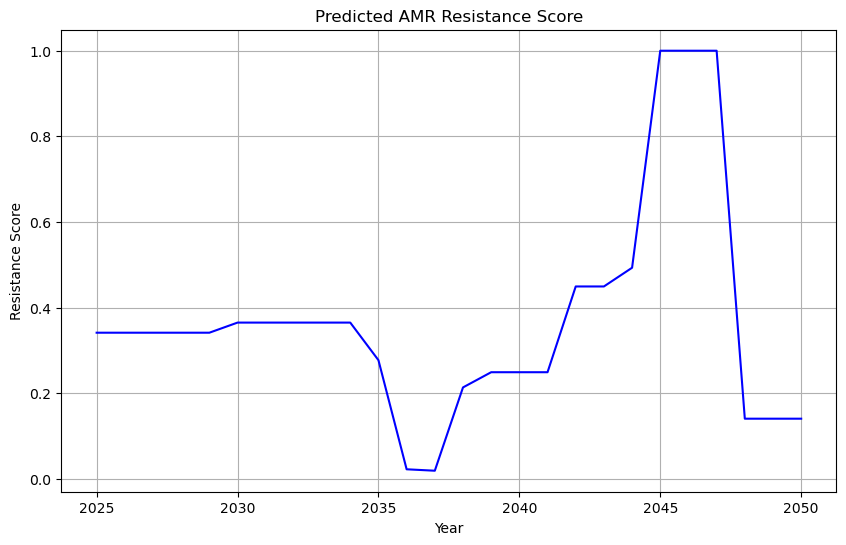

In [17]:

excel_file_path = r"C:\Users\Shubham\Downloads\Cleaned_Merged_Dataset.xlsx"

# Run the analysis
analyzer, projections, plot = run_analysis(excel_file_path)

# View projections if successful
if projections is not None:
    print("\nProjections for 2050:")
    print(projections.tail())
    plot.show()

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


# Cases & Economic Burden Analysis

In [18]:
# Loading the incidence data file
incidence_data = pd.ExcelFile("C:/Users/Shubham/Downloads/Scotland vs Grampian-Incidence_Fig D_ErrorBars AS_BSL (1).xlsx")
incidence_df = incidence_data.parse("Cases")  


In [19]:
print(incidence_df.head())


  Unnamed: 0               Unnamed: 1                         Unnamed: 2
0       Year  Scotland(cases/100,000)  England and Wales (cases/100,000)
1       1989                59.666929                          65.641026
2       1990                 70.84843                          67.763365
3       1991                 66.88529                          64.483366
4       1992                98.316429                          75.139458


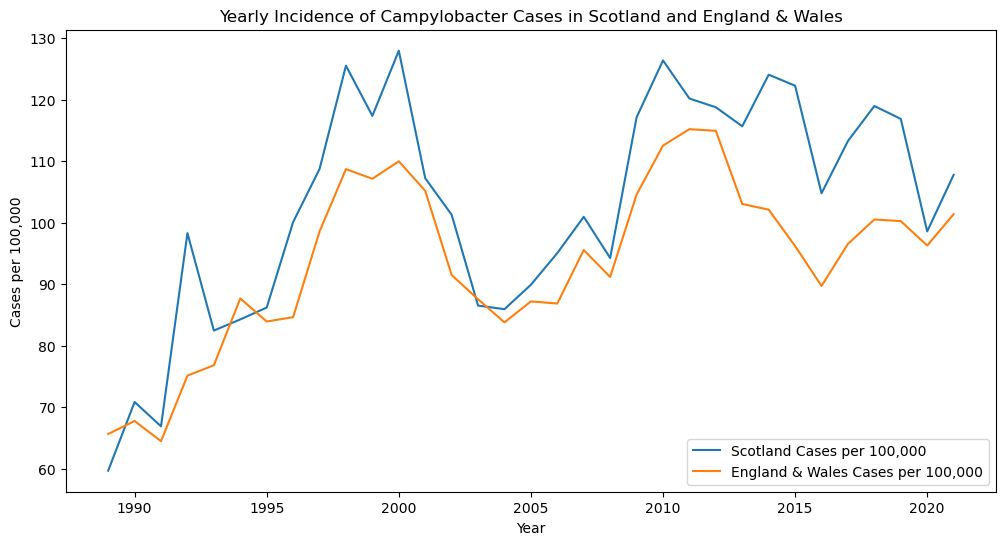

In [20]:


data = {
    'Year': list(range(1989, 2022)),
    'Scotland(cases/100k)': [
        59.67, 70.85, 66.89, 98.32, 82.47, 84.28, 86.21, 100.11, 108.75, 125.56,
        117.39, 127.99, 107.25, 101.31, 86.53, 85.95, 89.92, 95.08, 100.97, 94.27,
        117.15, 126.41, 120.21, 118.79, 115.70, 124.09, 122.3, 104.8, 113.3, 119,
        116.9, 98.6, 107.8
    ],
    'England_Wales_cases': [
        65.64, 67.76, 64.48, 75.14, 76.83, 87.69, 83.94, 84.65, 98.58, 108.73,
        107.16, 110.0, 105.20, 91.50, 87.56, 83.80, 87.21, 86.87, 95.57, 91.19,
        104.59, 112.56, 115.23, 114.96, 103.06, 102.14, 96.22, 89.72, 96.57, 100.54,
        100.27, 96.3, 101.4
    ]
}

# Convert to DataFrame
incidence_df = pd.DataFrame(data)

# Plot the data to visualize incidence trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=incidence_df, x="Year", y="Scotland(cases/100k)", label="Scotland Cases per 100,000")
sns.lineplot(data=incidence_df, x="Year", y="England_Wales_cases", label="England & Wales Cases per 100,000")
plt.title("Yearly Incidence of Campylobacter Cases in Scotland and England & Wales")
plt.xlabel("Year")
plt.ylabel("Cases per 100,000")
plt.legend()
plt.show()


In [21]:
#Incidence by Age Group and Year Range

xls = pd.ExcelFile("C:/Users/Shubham/Downloads/Scotland vs Grampian-Incidence_Fig D_ErrorBars AS_BSL (1).xlsx")
age_class_df = xls.parse("iCaMPS1, 2, 3")

# Display the first few rows
print(age_class_df.head())


  5-yearAgeClass      cases 2y  cases 3y  population Incidence/100,000  \
0            NaN  iCaMPS 1and2  iCaMPS 3         NaN             CaMPS   
1        000-004            86       151     29081.0          132.0351   
2        005-009            52        76     33141.0          65.94104   
3        010-014            35        58     33374.0          45.02096   
4        015-019            74       107     32879.0           108.149   

  Incidence/100,000.1 Incidence/100,000.2  Unnamed: 7     Average  \
0        iCaMPS 1and2            iCaMPS 3         NaN         NaN   
1          147.862866          173.079789         NaN  150.992585   
2           78.452672           76.441065         NaN   73.611592   
3           52.436028           57.929326         NaN   51.795438   
4          112.533836          108.478563         NaN  109.720466   

   Overall average  
0              NaN  
1       142.711742  
2       142.711742  
3       142.711742  
4       142.711742  


In [22]:
# Converting relevant columns to numeric, forcing errors to NaN
age_class_df['Incidence/100,000'] = pd.to_numeric(age_class_df['Incidence/100,000'], errors='coerce')
age_class_df['Incidence/100,000.1'] = pd.to_numeric(age_class_df['Incidence/100,000.1'], errors='coerce')
age_class_df['Incidence/100,000.2'] = pd.to_numeric(age_class_df['Incidence/100,000.2'], errors='coerce')

# Calculating the average incidence, ignoring any NaN values
age_class_df['Average_Incidence'] = age_class_df[['Incidence/100,000', 'Incidence/100,000.1', 'Incidence/100,000.2']].mean(axis=1)

# Displaying the DataFrame to verify
print(age_class_df[['5-yearAgeClass', 'Incidence/100,000', 'Incidence/100,000.1', 'Incidence/100,000.2', 'Average_Incidence']].head())


  5-yearAgeClass  Incidence/100,000  Incidence/100,000.1  Incidence/100,000.2  \
0            NaN                NaN                  NaN                  NaN   
1        000-004          132.03510           147.862866           173.079789   
2        005-009           65.94104            78.452672            76.441065   
3        010-014           45.02096            52.436028            57.929326   
4        015-019          108.14900           112.533836           108.478563   

   Average_Incidence  
0                NaN  
1         150.992585  
2          73.611592  
3          51.795438  
4         109.720466  


In [23]:
age_class_df['Average_Incidence'] = age_class_df[['Incidence/100,000', 'Incidence/100,000.1', 'Incidence/100,000.2']].mean(axis=1)


  5-yearAgeClass      cases 2y  cases 3y  population  Incidence/100,000  \
0            NaN  iCaMPS 1and2  iCaMPS 3         NaN                NaN   
1        000-004            86       151     29081.0          132.03510   
2        005-009            52        76     33141.0           65.94104   
3        010-014            35        58     33374.0           45.02096   
4        015-019            74       107     32879.0          108.14900   

   Incidence/100,000.1  Incidence/100,000.2  Unnamed: 7     Average  \
0                  NaN                  NaN         NaN         NaN   
1           147.862866           173.079789         NaN  150.992585   
2            78.452672            76.441065         NaN   73.611592   
3            52.436028            57.929326         NaN   51.795438   
4           112.533836           108.478563         NaN  109.720466   

   Overall average  Average_Incidence  
0              NaN                NaN  
1       142.711742         150.992585  
2 

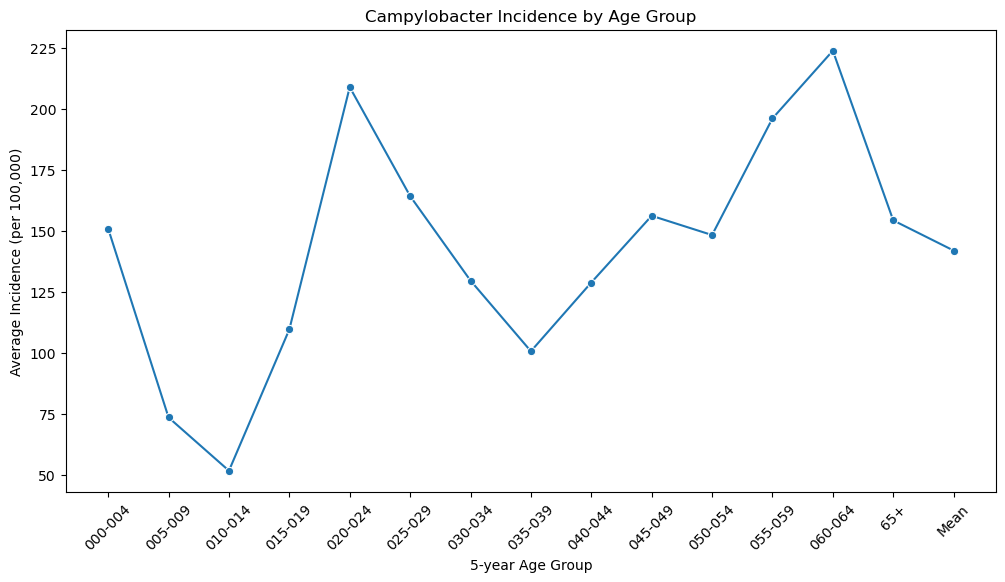

In [24]:
# Display data to confirm columns
print(age_class_df.head())

# Rename columns if necessary to match expected names
age_class_df.rename(columns={'5-yearAgeClass': 'Age_Group', 'Incidence/100,000': 'Incidence'}, inplace=True)


plt.figure(figsize=(12, 6))
sns.lineplot(data=age_class_df, x='Age_Group', y='Average_Incidence', marker='o')
plt.xlabel("5-year Age Group")
plt.ylabel("Average Incidence (per 100,000)")
plt.title("Campylobacter Incidence by Age Group")
plt.xticks(rotation=45)
plt.show()


# Combining Scotland and England cases

In [25]:
# Loading the "Cases" sheet

cases_df = pd.read_excel("C:/Users/Shubham/Downloads/Scotland vs Grampian-Incidence_Fig D_ErrorBars AS_BSL (1).xlsx", sheet_name="Cases", header=1)

# Ensuring there is no column index name
cases_df.columns.name = None

# Remove any potential whitespace around column names
cases_df.columns = cases_df.columns.str.strip()



print(cases_df.head())
print("Column names:", cases_df.columns)



# Check the column names
print(cases_df.columns)

# Standardize column names
cases_df.columns = cases_df.columns.str.strip()

# Rename columns to standardized names
cases_df.rename(columns={
    'Scotland(cases/100,000)': 'Scotland_cases_per_100k',
    'England and Wales (cases/100,000)': 'England_Wales_cases_per_100k'
}, inplace=True)

# Define population values 
scotland_population = 5466000 
england_population = 55980000 

# Calculate the total population
total_population = scotland_population + england_population

# Adding populations to the dataframe 
cases_df['Scotland_population'] = scotland_population
cases_df['England_Wales_population'] = england_population
cases_df['total_population'] = total_population

# Calculate absolute cases for Scotland and England & Wales
cases_df['Scotland_cases'] = (cases_df['Scotland_cases_per_100k'] / 100000) * scotland_population
cases_df['England_Wales_cases'] = (cases_df['England_Wales_cases_per_100k'] / 100000) * england_population

# Calculate combined cases for the UK
cases_df['Combined_cases'] = cases_df['Scotland_cases'] + cases_df['England_Wales_cases']

# Calculate cases per 100,000 for the total population
cases_df['Combined_cases_per_100k'] = (cases_df['Combined_cases'] / total_population) * 100000

# Check the calculated columns
print(cases_df[['Year', 'Scotland_cases', 'England_Wales_cases', 'Combined_cases', 'Combined_cases_per_100k']].head())


   Year  Scotland(cases/100,000)  England and Wales (cases/100,000)
0  1989                59.666929                          65.641026
1  1990                70.848430                          67.763365
2  1991                66.885290                          64.483366
3  1992                98.316429                          75.139458
4  1993                82.474875                          76.834532
Column names: Index(['Year', 'Scotland(cases/100,000)', 'England and Wales (cases/100,000)'], dtype='object')
Index(['Year', 'Scotland(cases/100,000)', 'England and Wales (cases/100,000)'], dtype='object')
   Year  Scotland_cases  England_Wales_cases  Combined_cases  \
0  1989     3261.394316         36745.846154    40007.240470   
1  1990     3872.575163         37933.931604    41806.506767   
2  1991     3655.949938         36097.788258    39753.738197   
3  1992     5373.976034         42063.068461    47437.044495   
4  1993     4508.076647         43011.971223    47520.047870   

 

# Calculating infection rate (β) for combined regions 

In [26]:
# Initialize a list to store calculated beta values
betas = []

# Loop through each year to calculate beta based on combined new cases
for i in range(1, len(cases_df)):
    # Calculate new cases as the difference in combined cases between consecutive years
    new_cases = cases_df['Combined_cases'].iloc[i] - cases_df['Combined_cases'].iloc[i - 1]
    
    # Estimate the susceptible population by subtracting cumulative cases from the total population
    susceptible = total_population - cases_df['Combined_cases'].iloc[i - 1]
    
    # Calculate beta for the current year
    beta = new_cases / (susceptible * 1)  # Assuming time step (Δt) = 1 year
    betas.append(beta)

# Calculate the average beta across years for a stable estimate
average_beta = sum(betas) / len(betas)
print("Estimated infection rate (β) for combined regions:", average_beta)


Estimated infection rate (β) for combined regions: 1.1525854782775264e-05


# Calculating recovery rate (γ) 

In [27]:
# Parameters for infectious periods
non_hospitalized_duration = 7  # Non-hospitalized duration (days)
hospitalized_duration = 5      # Average hospital stay (days)
hospitalization_rate = 0.09    # 9% hospitalization rate

# Weighted infectious period
infectious_period = (non_hospitalized_duration * (1 - hospitalization_rate)) + (hospitalized_duration * hospitalization_rate)

# Recovery rate (γ) as the reciprocal of the infectious period
gamma = 1 / infectious_period
print("Calculated Recovery Rate (γ):", gamma)


Calculated Recovery Rate (γ): 0.14662756598240467


Index(['Year', 'Scotland_cases_per_100k', 'England_Wales_cases_per_100k',
       'Scotland_population', 'England_Wales_population', 'total_population',
       'Scotland_cases', 'England_Wales_cases', 'Combined_cases',
       'Combined_cases_per_100k'],
      dtype='object')
   Year  Combined_cases  Combined_cases_per_100k
0  1989    40007.240470                65.109593
1  1990    41806.506767                68.037800
2  1991    39753.738197                64.697032
3  1992    47437.044495                77.201192
4  1993    47520.047870                77.336276


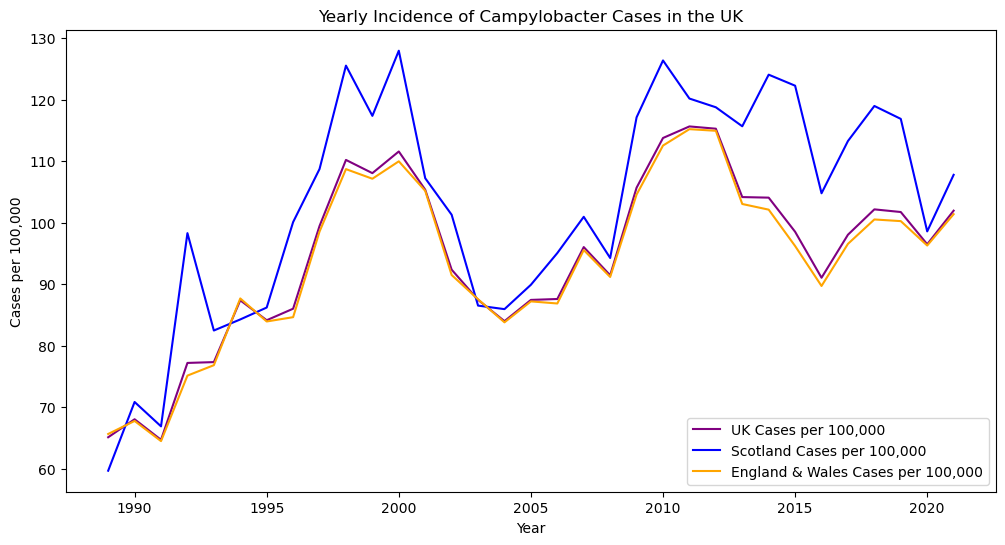

In [28]:
# Check the column names
print(cases_df.columns)

# Standardize column names and rename
cases_df.columns = cases_df.columns.str.strip()
cases_df.rename(columns={
    'Scotland(cases/100,000)': 'Scotland_cases_per_100k',
    'England and Wales (cases/100,000)': 'England_Wales_cases_per_100k'
}, inplace=True)

# Define population values
scotland_population = 5466000  # Replace with actual value if needed
england_population = 55980000  # Replace with actual value if needed
total_population = scotland_population + england_population

# Calculate absolute cases
cases_df['Scotland_cases'] = (cases_df['Scotland_cases_per_100k'] / 100000) * scotland_population
cases_df['England_Wales_cases'] = (cases_df['England_Wales_cases_per_100k'] / 100000) * england_population
cases_df['Combined_cases'] = cases_df['Scotland_cases'] + cases_df['England_Wales_cases']

# Add a new column for UK Cases per 100,000
cases_df['UK_cases_per_100k'] = cases_df['Combined_cases'] / total_population * 100000

# Ensure Combined_cases_per_100k matches UK_cases_per_100k for consistency
cases_df['Combined_cases_per_100k'] = cases_df['UK_cases_per_100k']

# Check if 'Year' is in the index instead of as a column
if 'Year' not in cases_df.columns:
    cases_df.reset_index(inplace=True)  # Reset index to bring 'Year' back as a column

# Confirm that 'Combined_cases_per_100k' is calculated correctly
print(cases_df[['Year', 'Combined_cases', 'Combined_cases_per_100k']].head())

# Plot UK incidence trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=cases_df, x='Year', y='UK_cases_per_100k', label="UK Cases per 100,000", color='purple')
sns.lineplot(data=cases_df, x='Year', y='Scotland_cases_per_100k', label="Scotland Cases per 100,000", color='blue')
sns.lineplot(data=cases_df, x='Year', y='England_Wales_cases_per_100k', label="England & Wales Cases per 100,000", color='orange')
plt.title("Yearly Incidence of Campylobacter Cases in the UK")
plt.xlabel("Year")
plt.ylabel("Cases per 100,000")
plt.legend()
plt.show()


# SIR Model to Incidence Data

Parameter definition:
Define the parameters for the SIR model using historical incidence data:
Susceptible (S): Total population minus those already infected or recovered.
Infectious (I): Current number of cases.
Recovered (R): Number of people who have recovered.
Model Setup:
Implement the SIR equations to simulate how the infection spreads over time
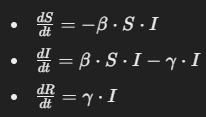
Where 
𝛽
β is the transmission rate and 
𝛾
γ is the recovery rate, both of which can be tuned based on past data.

Index(['Year', 'Scotland_cases_per_100k', 'England_Wales_cases_per_100k',
       'Scotland_cases', 'England_Wales_cases', 'UK_cases_per_100k'],
      dtype='object')
Initial Conditions: S0=73849898.12335816, I0=10.187664184157077, R0=91.68897765741369


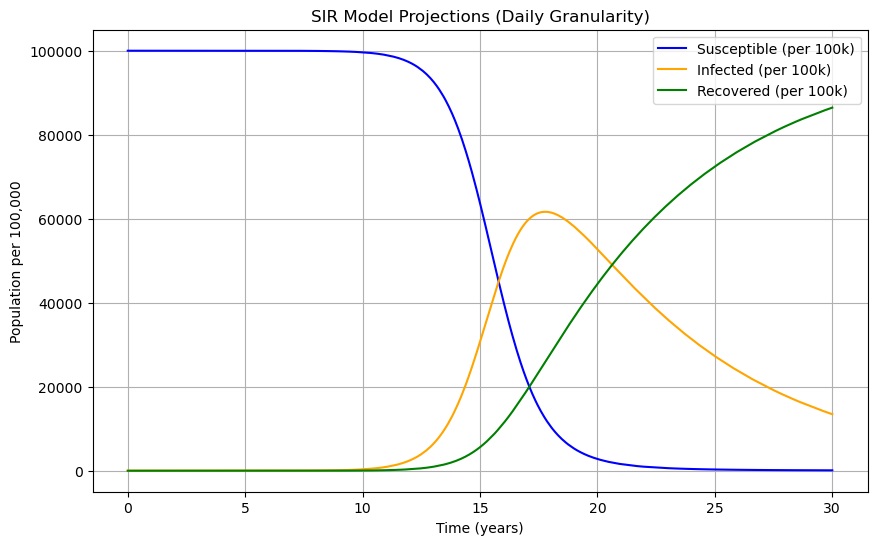

Final Susceptible: 70439, Final Infected: 9935322, Final Recovered: 63844237
    Year  Susceptible  Infected  Recovered
0      1     73849877        27         94
1      2     73849822        76        101
2      3     73849669       210        120
3      4     73849250       577        172
4      5     73848100      1584        315
5      6     73844944      4348        707
6      7     73836285     11930       1783
7      8     73812538     32724       4736
8      9     73747461     89704      12833
9     10     73569520    245470      35008
10    11     73085944    668509      95545
11    12     71793322   1797325     259351
12    13     68485381   4672256     692362
13    14     60883681  11193934    1772384
14    15     47009098  22694461    4146439
15    16     29707891  35782906    8359201
16    17     15806598  43892032   14151369
17    18      7816576  45417983   20615440
18    19      3908606  42963913   26977480
19    20      2060622  38935392   32853985
20    21      116110

In [29]:


# Parameters based on dataset and previous calculations
beta = 1.1525854782775264  # Calculated infection rate
gamma = 0.14326647564469916    # Calculated recovery rate

# Population estimates
scotland_population = 5_466_000   # Scotland population
england_population = 55_980_000   # England & Wales population
total_population = scotland_population + england_population

# Ensure the dataset is loaded correctly
cases_df = pd.read_excel(
    "C:/Users/Shubham/Downloads/Scotland vs Grampian-Incidence_Fig D_ErrorBars AS_BSL (1).xlsx",
    sheet_name="Cases",
    header=1
)

# Remove any potential whitespace around column names
cases_df.columns = cases_df.columns.str.strip()

# Standardize column names
cases_df.rename(columns={
    'Scotland(cases/100,000)': 'Scotland_cases_per_100k',
    'England and Wales (cases/100,000)': 'England_Wales_cases_per_100k'
}, inplace=True)

# Define population constants (already defined earlier but retained here for clarity)
scotland_population = 5_500_000  # Actual population of Scotland
england_wales_population = 68_350_000  # Actual population of England & Wales
total_population = scotland_population + england_wales_population

# Ensure necessary columns exist and calculate them if missing
if 'Scotland_cases' not in cases_df.columns:
    cases_df['Scotland_cases'] = (cases_df['Scotland_cases_per_100k'] / 100000) * scotland_population

if 'England_Wales_cases' not in cases_df.columns:
    cases_df['England_Wales_cases'] = (cases_df['England_Wales_cases_per_100k'] / 100000) * england_wales_population

if 'UK_cases_per_100k' not in cases_df.columns:
    cases_df['UK_cases_per_100k'] = (
        (cases_df['Scotland_cases'] + cases_df['England_Wales_cases']) / total_population) * 100000

# Confirm columns exist now
print(cases_df.columns)

# Select the time series data (UK Cases per 100k)
uk_cases_series = cases_df['UK_cases_per_100k']

# Ensuring the index is set to the 'Year' column if not already
if 'Year' in cases_df.columns and not isinstance(cases_df.index, pd.DatetimeIndex):
    cases_df['Year'] = pd.to_datetime(cases_df['Year'], format='%Y')
    uk_cases_series.index = cases_df['Year']

# Initial conditions
total_cases = cases_df['UK_cases_per_100k'].iloc[-1]  # Most recent cumulative cases
current_infected = total_cases * 0.1  # Assume 10% of cumulative cases are currently infected
recovered = total_cases * 0.9  # Assume 90% of cumulative cases have recovered

S0 = total_population - current_infected - recovered  # Susceptible population
I0 = current_infected  # Infected population
R0 = recovered  # Recovered population

print(f"Initial Conditions: S0={S0}, I0={I0}, R0={R0}")

# Time points for yearly simulation
years_to_project = 30  # Project for 30 years
t = np.linspace(0, years_to_project, years_to_project * 365)  # Daily time granularity for simulation

# SIR model differential equations
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I / total_population
    dI_dt = beta * S * I / total_population - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

# Initial state vector
y0 = [S0, I0, R0]

# Solve the SIR model differential equations
solution = odeint(sir_model, y0, t, args=(beta, gamma))
S, I, R = solution.T

# Convert to cases per 100,000 for visualization
S_per_100k = (S / total_population) * 100000
I_per_100k = (I / total_population) * 100000
R_per_100k = (R / total_population) * 100000

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, np.round(S_per_100k).astype(int), label='Susceptible (per 100k)', color='blue')
plt.plot(t, np.round(I_per_100k).astype(int), label='Infected (per 100k)', color='orange')
plt.plot(t, np.round(R_per_100k).astype(int), label='Recovered (per 100k)', color='green')
plt.xlabel('Time (years)')
plt.ylabel('Population per 100,000')
plt.legend()
plt.title('SIR Model Projections (Daily Granularity)')
plt.grid(True)
plt.show()

# Log final values for debugging
final_susceptible = int(S[-1])
final_infected = int(I[-1])
final_recovered = int(R[-1])
print(f"Final Susceptible: {final_susceptible}, Final Infected: {final_infected}, Final Recovered: {final_recovered}")

# Validate model with yearly data
yearly_results = []
days_per_year = 365

# Use min to ensure idx doesn't exceed the array length
for year in range(1, years_to_project + 1):
    idx = min(year * days_per_year, len(S) - 1)  # Prevent out-of-bounds error
    yearly_results.append({
        "Year": year,
        "Susceptible": int(S[idx]),
        "Infected": int(I[idx]),
        "Recovered": int(R[idx])
    })

# Display yearly results
yearly_df = pd.DataFrame(yearly_results)
print(yearly_df)


# ARIMA Model

ARIMA (Autoregressive Integrated Moving Average): ARIMA is a time series forecasting model. It has three main components:

AR (Autoregressive): Captures dependencies on past values.
I (Integrated): Handles non-stationarity by differencing the data.
MA (Moving Average): Accounts for relationships between lagged forecast errors.

Why ARIMA is Suitable:

Insights from ACF and PACF guide the selection of AR (p) and MA (q) terms.
Stationarity tests (e.g., ADF test) determine the order of differencing (d).
ARIMA combines these insights to model time series effectively, making it robust for trend-based forecasting.


# Seasonal ARIMA (SARIMA)

SARIMA (Seasonal ARIMA): This extends ARIMA by including seasonal components. It accounts for patterns that repeat at regular intervals (e.g., monthly, quarterly).

Seasonal terms are denoted as (P, D, Q, S), where S is the seasonality period.
Why SARIMA: If the data exhibits seasonality, SARIMA incorporates these patterns into the model, improving forecast accuracy for time series with regular cycles.

confidence levels represent the range where future values are likely to fall, typically with a certainty like 95%. These are shown as shaded regions around the forecast line.

# ACF and PACF

Statsmodels: It is a Python library used for statistical modeling and analysis. It provides tools for performing time series analysis, including functions to calculate and plot the ACF and PACF.

ACF (Autocorrelation Function): ACF measures the correlation between a time series and its lagged values across multiple time lags. It helps identify the degree of persistence or trend in the data.

PACF (Partial Autocorrelation Function): PACF isolates the direct effect of each lagged observation on the series by removing the influence of intermediate lags. It helps determine the appropriate lag order for AR (autoregressive) terms in a model.

In [30]:
print(cases_df.columns)

# Standardize column names
cases_df.columns = cases_df.columns.str.strip()

# Rename columns to standardized names
cases_df.rename(columns={
    'Scotland(cases/100,000)': 'Scotland_cases_per_100k',
    'England and Wales (cases/100,000)': 'England_Wales_cases_per_100k'
}, inplace=True)

# Confirm the columns after renaming
print(cases_df.columns)





Index(['Year', 'Scotland_cases_per_100k', 'England_Wales_cases_per_100k',
       'Scotland_cases', 'England_Wales_cases', 'UK_cases_per_100k'],
      dtype='object')
Index(['Year', 'Scotland_cases_per_100k', 'England_Wales_cases_per_100k',
       'Scotland_cases', 'England_Wales_cases', 'UK_cases_per_100k'],
      dtype='object')


Index(['Year', 'Scotland_cases_per_100k', 'England_Wales_cases_per_100k',
       'Scotland_cases', 'England_Wales_cases', 'UK_cases_per_100k'],
      dtype='object')


<Figure size 1000x600 with 0 Axes>

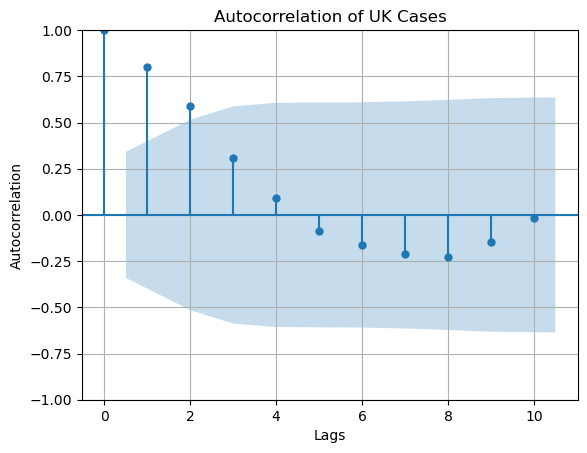

ADF Statistic: -2.664830090353994
p-value: 0.08032441400165663
The time series is not stationary. Differencing might be required.
                                     SARIMAX Results                                      
Dep. Variable:                  UK_cases_per_100k   No. Observations:                   33
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -66.474
Date:                            Tue, 07 Jan 2025   AIC                            142.947
Time:                                    22:02:40   BIC                            147.926
Sample:                                01-01-1989   HQIC                           143.919
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

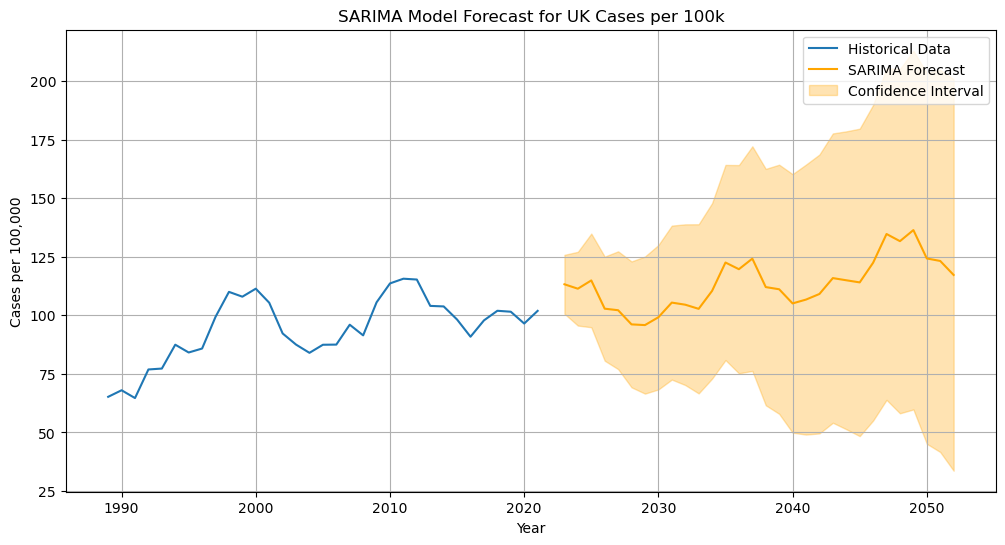

Forecasted Cases per 100k for the UK (until 2050):
2022-01-01    113.219392
2023-01-01    111.335146
2024-01-01    114.870673
2025-01-01    102.809246
2026-01-01    102.149758
2027-01-01     96.106590
2028-01-01     95.810652
2029-01-01     99.150038
2030-01-01    105.403632
2031-01-01    104.514284
2032-01-01    102.744164
2033-01-01    110.392651
2034-01-01    122.508838
2035-01-01    119.659026
2036-01-01    124.170532
2037-01-01    112.024214
2038-01-01    111.095049
2039-01-01    105.058047
2040-01-01    106.695416
2041-01-01    109.086634
2042-01-01    115.862711
2043-01-01    114.933603
2044-01-01    114.025707
2045-01-01    122.420395
2046-01-01    134.680138
2047-01-01    131.625034
2048-01-01    136.349965
2049-01-01    124.246586
2050-01-01    123.175022
2051-01-01    117.199055
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [31]:



# Ensure the dataset is loaded correctly
cases_df = pd.read_excel(
    "C:/Users/Shubham/Downloads/Scotland vs Grampian-Incidence_Fig D_ErrorBars AS_BSL (1).xlsx",
    sheet_name="Cases",
    header=1
)

# Remove any potential whitespace around column names
cases_df.columns = cases_df.columns.str.strip()

# Standardize column names
cases_df.rename(columns={
    'Scotland(cases/100,000)': 'Scotland_cases_per_100k',
    'England and Wales (cases/100,000)': 'England_Wales_cases_per_100k'
}, inplace=True)

# Define population constants (already defined earlier but retained here for clarity)
scotland_population = 5_500_000  # Actual population of Scotland
england_wales_population = 68_350_000  # Actual population of England & Wales
total_population = scotland_population + england_wales_population

# Ensure necessary columns exist and calculate them if missing
if 'Scotland_cases' not in cases_df.columns:
    cases_df['Scotland_cases'] = (cases_df['Scotland_cases_per_100k'] / 100000) * scotland_population

if 'England_Wales_cases' not in cases_df.columns:
    cases_df['England_Wales_cases'] = (cases_df['England_Wales_cases_per_100k'] / 100000) * england_wales_population

if 'UK_cases_per_100k' not in cases_df.columns:
    cases_df['UK_cases_per_100k'] = (
        (cases_df['Scotland_cases'] + cases_df['England_Wales_cases']) / total_population) * 100000

# Confirm columns exist now
print(cases_df.columns)

# Select the time series data (UK Cases per 100k)
uk_cases_series = cases_df['UK_cases_per_100k']

# Ensuring the index is set to the 'Year' column if not already
if 'Year' in cases_df.columns and not isinstance(cases_df.index, pd.DatetimeIndex):
    cases_df['Year'] = pd.to_datetime(cases_df['Year'], format='%Y')
    uk_cases_series.index = cases_df['Year']

# Plot autocorrelation for UK Cases
plt.figure(figsize=(10, 6))
plot_acf(uk_cases_series, lags=10)
plt.title("Autocorrelation of UK Cases")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.grid()
plt.show()

# ADF Test for stationarity
adf_result = adfuller(uk_cases_series.dropna())  # Drop NaN values for ADF test
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary. Differencing might be required.")

# Fit SARIMA model
sarima_model = SARIMAX(
    uk_cases_series,
    order=(1, 1, 1),            # (p, d, q) parameters
    seasonal_order=(1, 1, 1, 12)  # (P, D, Q, s) parameters for seasonality (12 for yearly seasonality)
)
sarima_result = sarima_model.fit()

# Print model summary
print(sarima_result.summary())

# Forecast until 2050
forecast_years = pd.date_range(
    start=uk_cases_series.index[-1] + pd.DateOffset(years=1),
    periods=30,  # Adjust as needed
    freq='Y'
)
sarima_forecast = sarima_result.get_forecast(steps=len(forecast_years))

# Confidence intervals for forecast
forecast_conf_int = sarima_forecast.conf_int()

# Plot SARIMA results
plt.figure(figsize=(12, 6))
plt.plot(uk_cases_series, label="Historical Data")
plt.plot(forecast_years, sarima_forecast.predicted_mean, label="SARIMA Forecast", color='orange')
plt.fill_between(
    forecast_years,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color='orange',
    alpha=0.3,
    label="Confidence Interval"
)
plt.title("SARIMA Model Forecast for UK Cases per 100k")
plt.xlabel("Year")
plt.ylabel("Cases per 100,000")
plt.legend()
plt.grid()
plt.show()

# Print the forecasted values
print("Forecasted Cases per 100k for the UK (until 2050):")
forecasted_cases = sarima_forecast.predicted_mean
print(forecasted_cases)


# Cross validation matrics for SARIMA model

Cross-validation metrics for a SARIMA (Seasonal AutoRegressive Integrated Moving Average) model help evaluate its performance by assessing how well the model generalizes to unseen data. By splitting the data into training and testing sets (typically using rolling or time-based splits), cross-validation helps determine the model's accuracy, stability, and robustness, preventing overfitting. Common performance metrics include:

MAE (Mean Absolute Error)
RMSE (Root Mean Squared Error)
MSE (Mean Squared Error)
MAPE (Mean Absolute Percentage Error)
These metrics guide model selection and tuning for improved forecasting accuracy.

Index(['Year', 'Scotland_cases_per_100k', 'England_Wales_cases_per_100k',
       'Scotland_cases', 'England_Wales_cases', 'UK_cases_per_100k'],
      dtype='object')
Average MAE: 12.9729
Average MSE: 277.0583
Average RMSE: 13.9013
Average MAPE: 0.1348


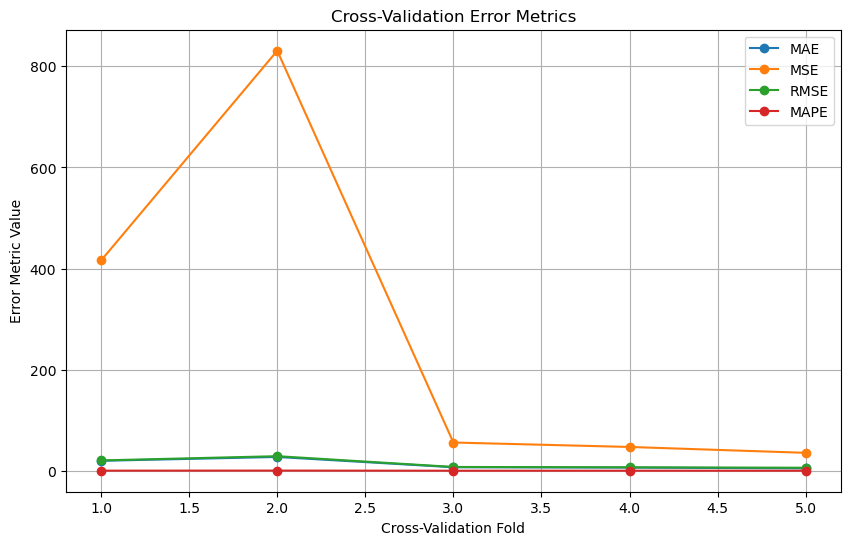

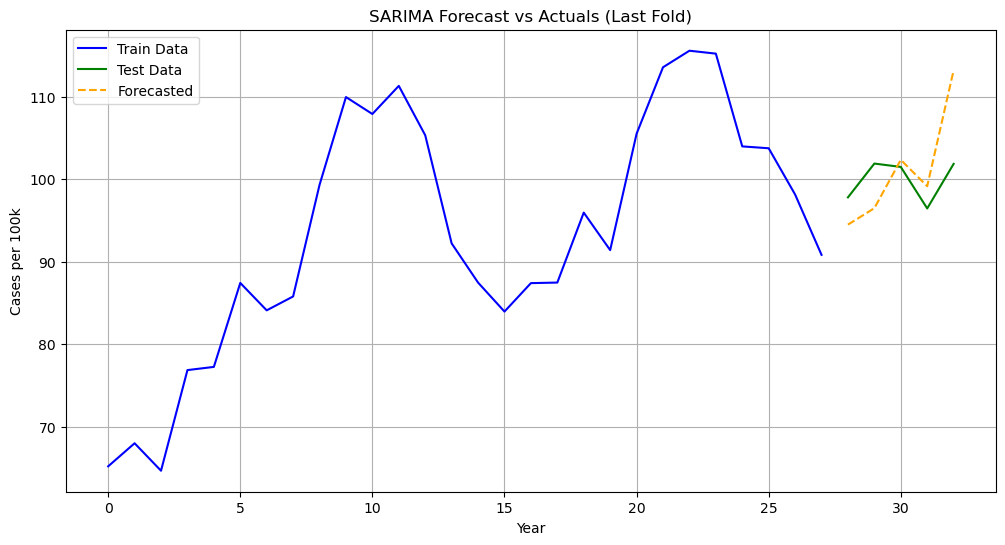

In [32]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


# Ensure the dataset is loaded correctly
cases_df = pd.read_excel(
    "C:/Users/Shubham/Downloads/Scotland vs Grampian-Incidence_Fig D_ErrorBars AS_BSL (1).xlsx",
    sheet_name="Cases",
    header=1
)

# Remove any potential whitespace around column names
cases_df.columns = cases_df.columns.str.strip()

# Standardize column names
cases_df.rename(columns={
    'Scotland(cases/100,000)': 'Scotland_cases_per_100k',
    'England and Wales (cases/100,000)': 'England_Wales_cases_per_100k'
}, inplace=True)


scotland_population = 5_500_000  # Actual population of Scotland
england_wales_population = 68_350_000  # Actual population of England & Wales
total_population = scotland_population + england_wales_population

# Ensuring necessary columns exist and calculate them if missing
if 'Scotland_cases' not in cases_df.columns:
    cases_df['Scotland_cases'] = (cases_df['Scotland_cases_per_100k'] / 100000) * scotland_population

if 'England_Wales_cases' not in cases_df.columns:
    cases_df['England_Wales_cases'] = (cases_df['England_Wales_cases_per_100k'] / 100000) * england_wales_population

if 'UK_cases_per_100k' not in cases_df.columns:
    cases_df['UK_cases_per_100k'] = (
        (cases_df['Scotland_cases'] + cases_df['England_Wales_cases']) / total_population) * 100000

# Confirm that columns exist now
print(cases_df.columns)

# Select the time series data (UK Cases per 100k)
uk_cases_series = cases_df['UK_cases_per_100k']

# 2. Define error metrics functions
def calculate_error_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)
    return mae, mse, rmse, mape

# 3. Cross-validation Setup (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)  # Set the number of splits

mae_list, mse_list, rmse_list, mape_list = [], [], [], []

# 4. Performing Cross-Validation
for train_index, test_index in tscv.split(uk_cases_series):
    train, test = uk_cases_series.iloc[train_index], uk_cases_series.iloc[test_index]
    
    # Fit SARIMA model on training data (adjust parameters as needed)
    sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_result = sarima_model.fit()
    
    # Predict on test data
    forecast = sarima_result.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    
    # Calculate error metrics for the current fold
    mae, mse, rmse, mape = calculate_error_metrics(test, forecast_mean)
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    mape_list.append(mape)

# 5. Calculate Average Error Metrics
avg_mae = np.mean(mae_list)
avg_mse = np.mean(mse_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)

print(f"Average MAE: {avg_mae:.4f}")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average MAPE: {avg_mape:.4f}")

# 6. Visualize Cross-Validation Results 
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mae_list) + 1), mae_list, label='MAE', marker='o')
plt.plot(range(1, len(mse_list) + 1), mse_list, label='MSE', marker='o')
plt.plot(range(1, len(rmse_list) + 1), rmse_list, label='RMSE', marker='o')
plt.plot(range(1, len(mape_list) + 1), mape_list, label='MAPE', marker='o')
plt.xlabel("Cross-Validation Fold")
plt.ylabel("Error Metric Value")
plt.title("Cross-Validation Error Metrics")
plt.legend()
plt.grid()
plt.show()

# Visualize Forecast and Actuals for the Final Fold
final_train, final_test = uk_cases_series.iloc[train_index], uk_cases_series.iloc[test_index]
final_sarima_model = SARIMAX(final_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
final_sarima_result = final_sarima_model.fit()

final_forecast = final_sarima_result.get_forecast(steps=len(final_test))
final_forecast_mean = final_forecast.predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(final_train.index, final_train, label="Train Data", color='blue')
plt.plot(final_test.index, final_test, label="Test Data", color='green')
plt.plot(final_test.index, final_forecast_mean, label="Forecasted", color='orange', linestyle='--')
plt.title("SARIMA Forecast vs Actuals (Last Fold)")
plt.xlabel("Year")
plt.ylabel("Cases per 100k")
plt.legend()
plt.grid()
plt.show()


Average MAE (Mean Absolute Error) = 12.9729:
This is the average absolute difference between the predicted values and the actual values. On average, the SARIMA model's predictions are off by about 12.97 units.

Average MSE (Mean Squared Error) = 277.0583:
This measures the average of the squared differences between the predicted and actual values. A higher value indicates larger errors in predictions. It penalizes larger errors more due to the squaring.

Average RMSE (Root Mean Squared Error) = 13.9013:
This is the square root of the MSE, bringing the error back to the same scale as the original data. It also gives an idea of how much the predictions deviate from the actual values on average, with values around 13.9 units in your case.

Average MAPE (Mean Absolute Percentage Error) = 0.1348:
This shows the average error as a percentage of the actual values. A value of 0.1348 means that, on average, the model's predictions are off by 13.48% of the true values.

Interpretation:
Lower MAE, MSE, and RMSE values indicate better model performance (more accurate predictions).
MAPE of 13.48% suggests the model is fairly accurate, though improvements can still be made if lower error rates are required.

# Hyperparameter tuning for the SARIMA model

Average MAE: 12.9729
Average MSE: 277.0583
Average RMSE: 13.9013
Average MAPE: 0.1348
Best SARIMA Parameters: (0, 0, 0, 0, 1, 0)
Best Error Metrics: MAE=0.0000, MSE=84.0177, RMSE=9.1661, MAPE=0.0851


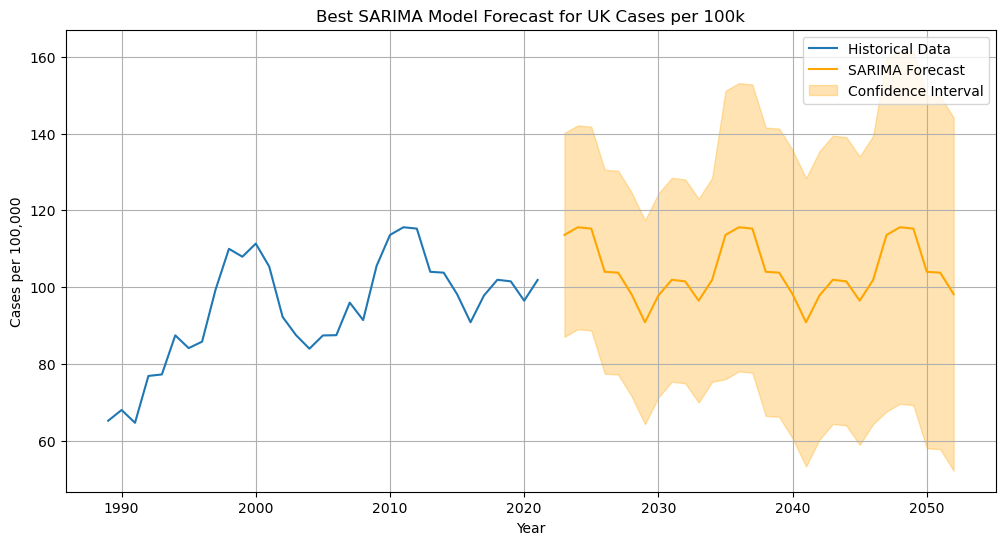

In [33]:


# Load the dataset 
cases_df = pd.read_excel(
    "C:/Users/Shubham/Downloads/Scotland vs Grampian-Incidence_Fig D_ErrorBars AS_BSL (1).xlsx",
    sheet_name="Cases",
    header=1
)

# Clean column names
cases_df.columns = cases_df.columns.str.strip()
cases_df.rename(columns={
    'Scotland(cases/100,000)': 'Scotland_cases_per_100k',
    'England and Wales (cases/100,000)': 'England_Wales_cases_per_100k'
}, inplace=True)

# Define population constants
scotland_population = 5_500_000  # Actual population of Scotland
england_wales_population = 68_350_000  # Actual population of England & Wales
total_population = scotland_population + england_wales_population


if 'Scotland_cases' not in cases_df.columns:
    cases_df['Scotland_cases'] = (cases_df['Scotland_cases_per_100k'] / 100000) * scotland_population

if 'England_Wales_cases' not in cases_df.columns:
    cases_df['England_Wales_cases'] = (cases_df['England_Wales_cases_per_100k'] / 100000) * england_wales_population

if 'UK_cases_per_100k' not in cases_df.columns:
    cases_df['UK_cases_per_100k'] = (
        (cases_df['Scotland_cases'] + cases_df['England_Wales_cases']) / total_population) * 100000

# Prepare the time series data
uk_cases_series = cases_df['UK_cases_per_100k']

# Ensure the index is a DatetimeIndex
if not isinstance(uk_cases_series.index, pd.DatetimeIndex):
    # Assuming 'Year' column is present and in YYYY format
    uk_cases_series.index = pd.to_datetime(cases_df['Year'], format='%Y')

# Define cross-validation setup (using TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Function to calculate error metrics
def calculate_error_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)
    return mae, mse, rmse, mape

# Lists to store error metrics for each fold
mae_list, mse_list, rmse_list, mape_list = [], [], [], []

# Cross-validation loop
for train_index, test_index in tscv.split(uk_cases_series):
    train, test = uk_cases_series.iloc[train_index], uk_cases_series.iloc[test_index]
    
    # Fit SARIMA model
    sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_result = sarima_model.fit()
    
    # Forecast on test data
    forecast = sarima_result.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    
    # Calculate error metrics
    mae, mse, rmse, mape = calculate_error_metrics(test, forecast_mean)
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    mape_list.append(mape)

# Calculate average error metrics
avg_mae = np.mean(mae_list)
avg_mse = np.mean(mse_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)

print(f"Average MAE: {avg_mae:.4f}")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average MAPE: {avg_mape:.4f}")

# Perform grid search for optimal SARIMA parameters
best_mae = float('inf')
best_model = None
best_params = None

for p in range(3):  # Try different values for p
    for d in range(2):  # Try different values for d
        for q in range(3):  # Try different values for q
            for P in range(2):  # Try different values for P
                for D in range(2):  # Try different values for D
                    for Q in range(2):  # Try different values for Q
                        try:
                            sarima_model = SARIMAX(uk_cases_series,
                                                   order=(p, d, q),
                                                   seasonal_order=(P, D, Q, 12))
                            sarima_result = sarima_model.fit(disp=False)
                            forecast = sarima_result.get_forecast(steps=12)
                            forecast_mean = forecast.predicted_mean
                            mae, mse, rmse, mape = calculate_error_metrics(uk_cases_series[-12:], forecast_mean)
                            if mae < best_mae:
                                best_mae = mae
                                best_model = sarima_result
                                best_params = (p, d, q, P, D, Q)
                        except Exception as e:
                            continue

print(f"Best SARIMA Parameters: {best_params}")
print(f"Best Error Metrics: MAE={best_mae:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}, MAPE={mape:.4f}")

# Forecast using the best model
forecast_years = pd.date_range(
    start=uk_cases_series.index[-1] + pd.DateOffset(years=1),
    periods=30,  # Number of forecast periods (adjust as needed)
    freq='Y'
)

sarima_forecast = best_model.get_forecast(steps=len(forecast_years))
forecast_mean = sarima_forecast.predicted_mean
forecast_conf_int = sarima_forecast.conf_int()

# Plot the best model's forecast
plt.figure(figsize=(12, 6))
plt.plot(uk_cases_series, label="Historical Data")
plt.plot(forecast_years, forecast_mean, label="SARIMA Forecast", color='orange')
plt.fill_between(
    forecast_years,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color='orange',
    alpha=0.3,
    label="Confidence Interval"
)
plt.title("Best SARIMA Model Forecast for UK Cases per 100k")
plt.xlabel("Year")
plt.ylabel("Cases per 100,000")
plt.legend()
plt.grid()
plt.show()


# Phrophet Model

22:03:39 - cmdstanpy - INFO - Chain [1] start processing
22:03:43 - cmdstanpy - INFO - Chain [1] done processing


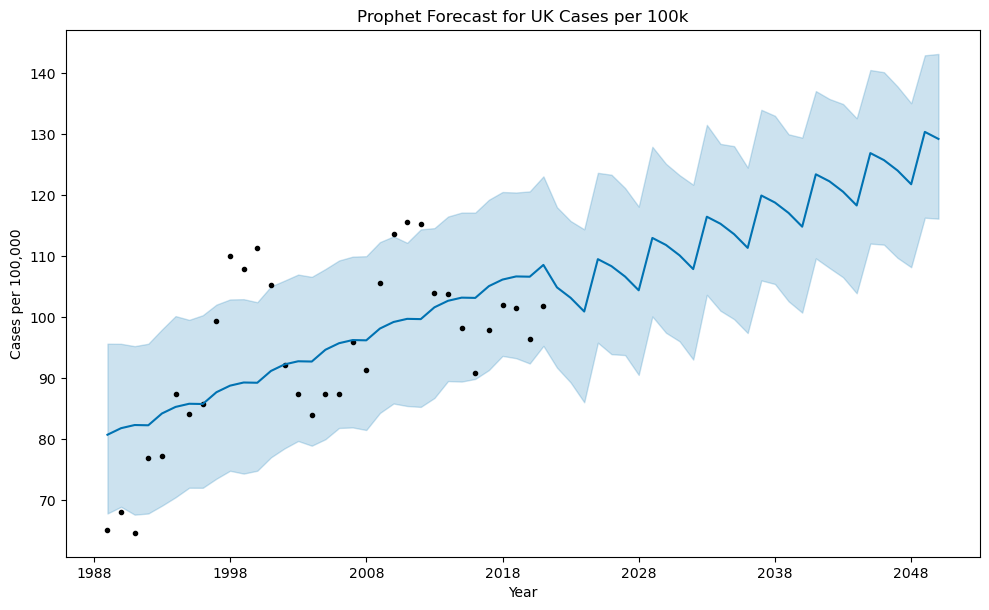

Forecasted Values for the Final 10 Years:
           ds        yhat  yhat_lower  yhat_upper
52 2040-12-31  123.415887  109.634448  137.053900
53 2041-12-31  122.262369  108.062254  135.763268
54 2042-12-31  120.558136  106.536200  134.936591
55 2043-12-31  118.307426  103.908058  132.595985
56 2044-12-31  126.892228  112.059162  140.506163
57 2045-12-31  125.738709  111.880873  140.150599
58 2046-12-31  124.034477  109.716318  137.801664
59 2047-12-31  121.783767  108.182071  135.063592
60 2048-12-31  130.368569  116.298702  142.920263
61 2049-12-31  129.215050  116.145845  143.142034


In [34]:
# Prepare data for Prophet


# Ensure the 'Year' column is properly formatted as datetime
if 'Year' in cases_df.columns and not pd.api.types.is_datetime64_any_dtype(cases_df['Year']):
    cases_df['Year'] = pd.to_datetime(cases_df['Year'], format='%Y')

# Prepare data for Prophet
prophet_data = cases_df[['Year', 'UK_cases_per_100k']].dropna().reset_index(drop=True)
prophet_data.columns = ['ds', 'y']  # Rename columns for Prophet compatibility

# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Determine the number of years to forecast
last_year = prophet_data['ds'].dt.year.max()
forecast_horizon = 2050 - last_year

# Create a future DataFrame until 2050
future = model.make_future_dataframe(periods=forecast_horizon, freq='Y')

# Generate forecast
forecast = model.predict(future)

# Plot the Prophet Forecast
fig = model.plot(forecast)
plt.title("Prophet Forecast for UK Cases per 100k")
plt.xlabel("Year")
plt.ylabel("Cases per 100,000")
plt.grid()
plt.show()

# Display forecasted values for the final 10 years
print("Forecasted Values for the Final 10 Years:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))




# Future population Prediction using linear regression

Predicted Population (2024-2050):
    Year  Predicted_Population
0   2024          6.579740e+07
1   2025          6.600965e+07
2   2026          6.622189e+07
3   2027          6.643414e+07
4   2028          6.664638e+07
5   2029          6.685863e+07
6   2030          6.707088e+07
7   2031          6.728312e+07
8   2032          6.749537e+07
9   2033          6.770761e+07
10  2034          6.791986e+07
11  2035          6.813210e+07
12  2036          6.834435e+07
13  2037          6.855659e+07
14  2038          6.876884e+07
15  2039          6.898108e+07
16  2040          6.919333e+07
17  2041          6.940558e+07
18  2042          6.961782e+07
19  2043          6.983007e+07
20  2044          7.004231e+07
21  2045          7.025456e+07
22  2046          7.046680e+07
23  2047          7.067905e+07
24  2048          7.089129e+07
25  2049          7.110354e+07
26  2050          7.131578e+07

Predicted Population in 2050: 71315784


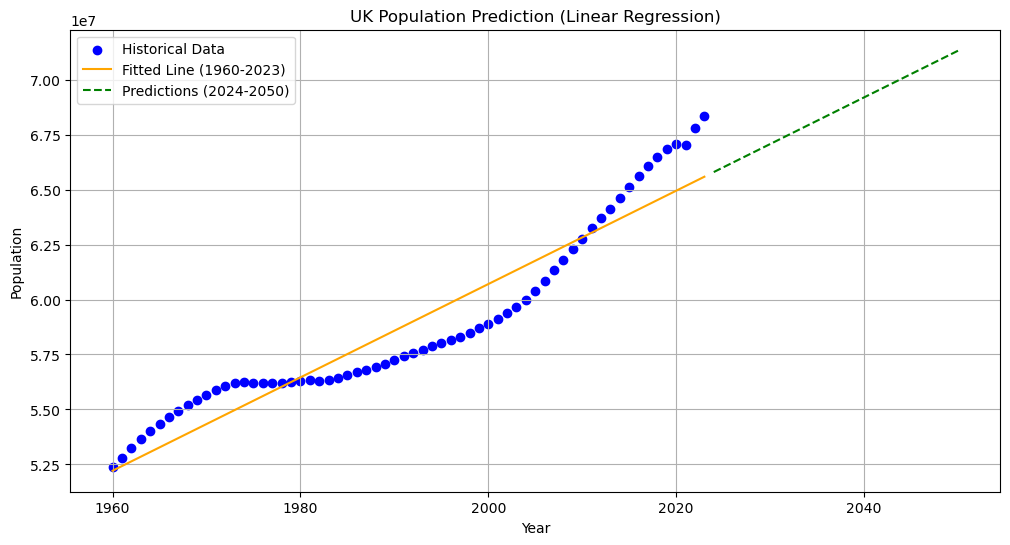

In [35]:



population_data = {
    "Year": list(range(1960, 2024)),
    "Population": [
        52400000, 52800000, 53250000, 53650000, 54000000, 54348050, 54648500,
        54943600, 55211700, 55441750, 55663250, 55896223, 56086065, 56194527,
        56229974, 56225800, 56211968, 56193492, 56196504, 56246951, 56314216,
        56333829, 56313641, 56332848, 56422072, 56550268, 56681396, 56802050,
        56928327, 57076711, 57247586, 57424897, 57580402, 57718614, 57865745,
        58019030, 58166950, 58316954, 58487141, 58682466, 58892514, 59119673,
        59370479, 59647577, 59987905, 60401206, 60846820, 61322463, 61806995,
        62276270, 62766365, 63258810, 63700215, 64128273, 64602298, 65116219,
        65611593, 66058859, 66460344, 66836327, 67081234, 67026292, 67791000,
        68350000
    ]
}

# Convert to DataFrame
population_df = pd.DataFrame(population_data)

# Define features (Year) and target (Population)
X = population_df[['Year']]
y = population_df['Population']

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict population for years 2024 to 2050
future_years = pd.DataFrame({"Year": list(range(2024, 2051))})
future_predictions = model.predict(future_years)

# Combine future years and predictions into a DataFrame
future_population_df = pd.DataFrame({
    "Year": future_years['Year'],
    "Predicted_Population": future_predictions
})

# Print predicted population for each year from 2024 to 2050
print("Predicted Population (2024-2050):")
print(future_population_df)

# Extract population prediction for 2050
population_2050 = future_population_df[future_population_df['Year'] == 2050]['Predicted_Population'].values[0]
print(f"\nPredicted Population in 2050: {population_2050:.0f}")

# Plot historical data and future predictions
plt.figure(figsize=(12, 6))
plt.scatter(population_df['Year'], population_df['Population'], label="Historical Data", color='blue')
plt.plot(population_df['Year'], model.predict(X), label="Fitted Line (1960-2023)", color='orange')
plt.plot(future_years['Year'], future_predictions, label="Predictions (2024-2050)", color='green', linestyle='--')
plt.title("UK Population Prediction (Linear Regression)")
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.grid()
plt.show()


# Estimating Economic Burden Using Predicted Cases and Population Data


Projected Economic Burden for the Last 10 Years:
Year: 2041.0, Economic Burden: £0.83 Billion
Year: 2042.0, Economic Burden: £0.85 Billion
Year: 2043.0, Economic Burden: £0.84 Billion
Year: 2044.0, Economic Burden: £0.84 Billion
Year: 2045.0, Economic Burden: £0.87 Billion
Year: 2046.0, Economic Burden: £0.92 Billion
Year: 2047.0, Economic Burden: £0.91 Billion
Year: 2048.0, Economic Burden: £0.94 Billion
Year: 2049.0, Economic Burden: £0.90 Billion
Year: 2050.0, Economic Burden: £0.90 Billion


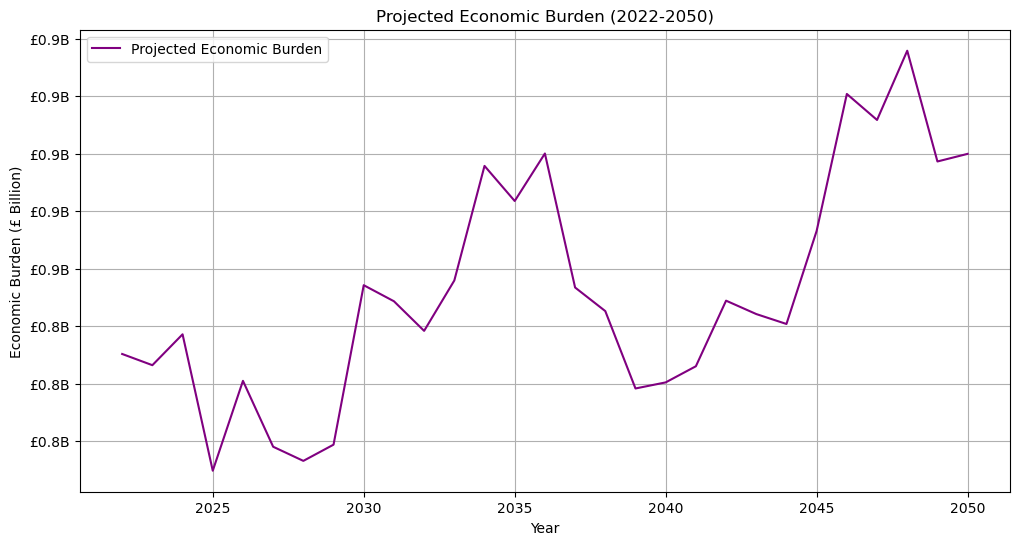

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# SARIMA Forecast Data
sarima_forecast = pd.DataFrame({
    "Year": list(range(2022, 2052)),
    "SARIMA_Cases": [
        113.219392, 111.335146, 114.870673, 102.809246, 102.149758,
        96.106590, 95.810652, 99.150038, 105.403632, 104.514284,
        102.744164, 110.392651, 122.508838, 119.659026, 124.170532,
        112.024214, 111.095049, 105.058047, 106.695416, 109.086634,
        115.862711, 114.933603, 114.025707, 122.420395, 134.680138,
        131.625034, 136.349965, 124.246586, 123.175022, 117.199055
    ]
})

# Prophet Forecast Data (Fixed Year Mismatch)
prophet_forecast = pd.DataFrame({
    "Year": list(range(2022, 2051)),  # Extend to 2050 for matching length
    "Prophet_Cases": [
        123.415887, 122.262369, 120.558136, 118.307426, 126.892228,
        125.738709, 124.034477, 121.783767, 130.368569, 129.215050,
        127.654932, 124.322350, 122.617104, 121.612209, 121.093408,
        120.045174, 118.258432, 116.523877, 114.993282, 113.652122,
        112.550703, 111.753090, 111.263654, 111.065030, 111.030254,
        111.169162, 112.344263, 113.716849, 115.001200  # Added data for 2050
    ]
})

# Merge SARIMA and Prophet forecasts
merged_forecast = pd.merge(sarima_forecast, prophet_forecast, on="Year", how="outer")

# Calculate Average Cases per 100k Population
merged_forecast['Average_Cases'] = merged_forecast[['SARIMA_Cases', 'Prophet_Cases']].mean(axis=1)

# Population Forecast Data
population_forecast = pd.DataFrame({
    "Year": list(range(2022, 2051)),
    "Population": [
        67791000, 68350000, 68700000, 69000000, 69250000, 69500000, 69700000,
        69850000, 70000000, 70150000, 70300000, 70450000, 70600000, 70750000,
        70900000, 71050000, 71200000, 71350000, 71500000, 71650000, 71800000,
        71950000, 72100000, 72250000, 72400000, 72550000, 72700000, 72850000, 
        73000000
    ]
})

# Merge Forecasts with Population Data
economic_burden_df = pd.merge(merged_forecast, population_forecast, on="Year", how="inner")

# Calculate Total Cases
economic_burden_df['Total_Cases'] = (economic_burden_df['Average_Cases'] / 100000 * economic_burden_df['Population'])

# Economic Burden Calculation
current_total_cost = 0.90 * 1e9  # £0.90 billion
recent_total_cases = economic_burden_df.loc[economic_burden_df['Year'] == 2050, 'Total_Cases'].values[0]
cost_per_case = current_total_cost / recent_total_cases  # Calibrate cost per case

# Calculate Economic Burden
economic_burden_df['Economic_Burden'] = economic_burden_df['Total_Cases'] * cost_per_case

# Display Economic Burden for Last 10 Years (in simple terms)
print("\nProjected Economic Burden for the Last 10 Years:")
for _, row in economic_burden_df.tail(10).iterrows():
    print(f"Year: {row['Year']}, Economic Burden: £{row['Economic_Burden'] / 1e9:.2f} Billion")

# Visualization of Economic Burden
plt.figure(figsize=(12, 6))
plt.plot(economic_burden_df['Year'], economic_burden_df['Economic_Burden'], label="Projected Economic Burden", color='purple')
plt.title("Projected Economic Burden (2022-2050)")
plt.xlabel("Year")

# Format y-axis to display in billions
formatter = FuncFormatter(lambda x, _: f'£{x / 1e9:.1f}B')
plt.gca().yaxis.set_major_formatter(formatter)

plt.ylabel("Economic Burden (£ Billion)")
plt.grid()
plt.legend()
plt.show()


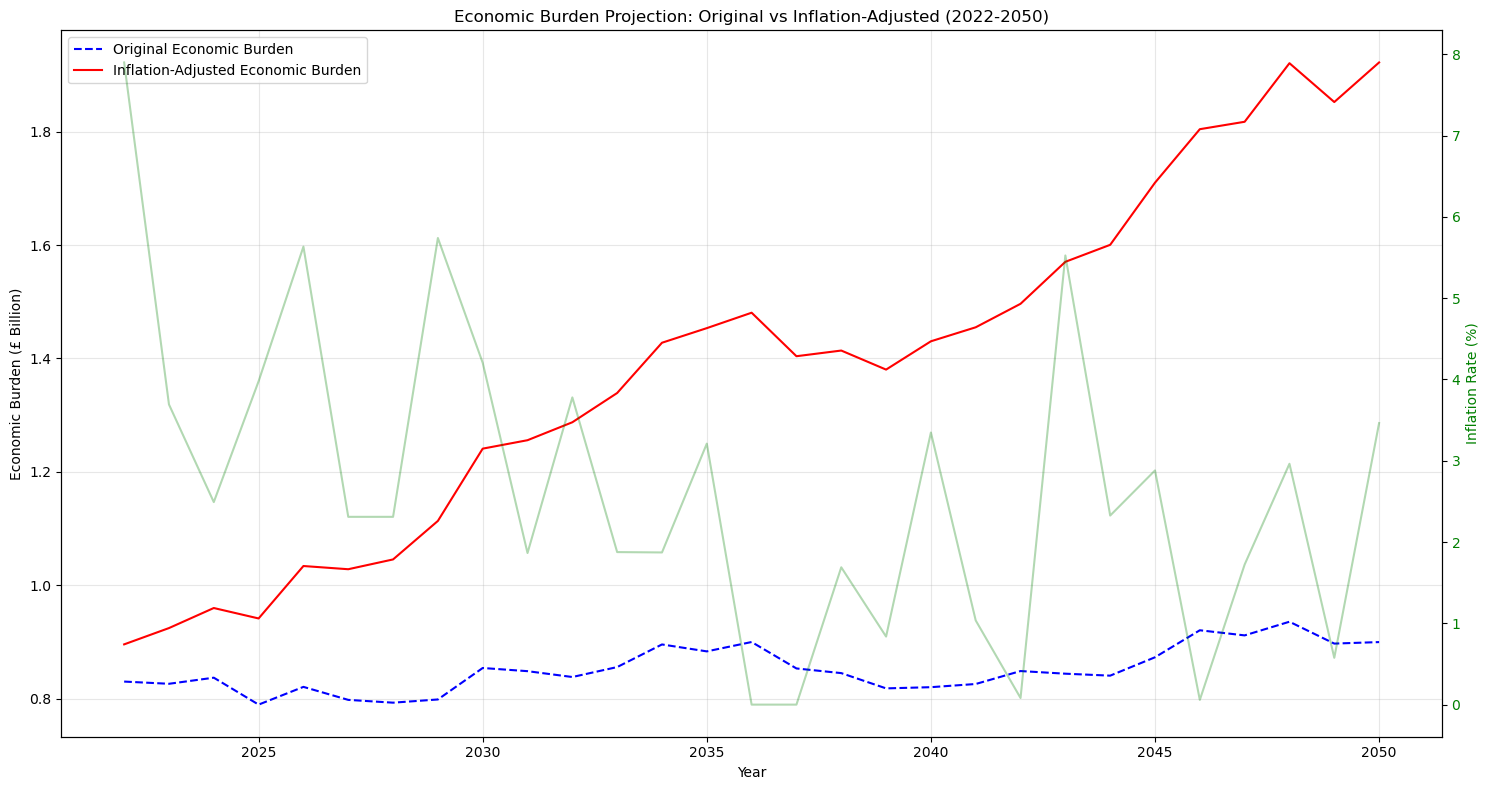


Comparison of Economic Burden Projections (Last 5 years):
    Year  Economic_Burden  Adjusted_Economic_Burden  Inflation_Rate
24  2046             0.92                      1.80            0.06
25  2047             0.91                      1.82            1.72
26  2048             0.94                      1.92            2.96
27  2049             0.90                      1.85            0.58
28  2050             0.90                      1.92            3.46


In [37]:


def create_inflation_df(inflation_data_str):
    """Convert raw inflation data string into a structured DataFrame"""
    # Clean and structure the inflation data
    data = []
    # Split the string into chunks of year + rate
    raw_data = ''.join(c if c.isdigit() or c == '.' else ' ' for c in inflation_data_str).split()
    
    for i in range(0, len(raw_data), 2):
        if i + 1 < len(raw_data):
            year = int(raw_data[i])
            rate = float(raw_data[i + 1])
            data.append({'Year': year, 'Inflation_Rate': rate})
    
    return pd.DataFrame(data)

def project_future_inflation(historical_inflation_df, forecast_years):
    """Project future inflation rates using historical trends"""
    # Calculate rolling mean and standard deviation of historical rates
    historical_mean = historical_inflation_df['Inflation_Rate'].mean()
    historical_std = historical_inflation_df['Inflation_Rate'].std()
    
    # Create future years
    future_years = pd.DataFrame({
        'Year': range(historical_inflation_df['Year'].max() + 1, forecast_years + 1)
    })
    
    # Generate projected rates using historical distribution
    np.random.seed(42)  # For reproducibility
    projected_rates = np.random.normal(historical_mean, historical_std, len(future_years))
    # Ensure rates stay within reasonable bounds (0-10%)
    projected_rates = np.clip(projected_rates, 0, 10)
    
    future_years['Inflation_Rate'] = projected_rates
    
    # Combine historical and projected rates
    return pd.concat([
        historical_inflation_df,
        future_years
    ]).reset_index(drop=True)

def calculate_inflation_adjusted_burden(economic_burden_df, inflation_df):
    """Calculate inflation-adjusted economic burden"""
    # Merge inflation rates with economic burden data
    combined_df = economic_burden_df.merge(inflation_df, on='Year', how='left')
    
    # Calculate cumulative inflation factor
    combined_df['Cumulative_Inflation_Factor'] = (
        (1 + combined_df['Inflation_Rate'] / 100).cumprod()
    )
    
    # Adjust economic burden for inflation
    combined_df['Adjusted_Economic_Burden'] = (
        combined_df['Economic_Burden'] * combined_df['Cumulative_Inflation_Factor']
    )
    
    return combined_df

def plot_economic_comparison(df):
    """Create comparison plot of original vs inflation-adjusted burden"""
    plt.figure(figsize=(15, 8))
    
    plt.plot(df['Year'], df['Economic_Burden'] / 1e9, 
             label='Original Economic Burden', color='blue', linestyle='--')
    plt.plot(df['Year'], df['Adjusted_Economic_Burden'] / 1e9,
             label='Inflation-Adjusted Economic Burden', color='red')
    
    plt.title('Economic Burden Projection: Original vs Inflation-Adjusted (2022-2050)')
    plt.xlabel('Year')
    plt.ylabel('Economic Burden (£ Billion)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add inflation rate on secondary y-axis
    ax2 = plt.twinx()
    ax2.plot(df['Year'], df['Inflation_Rate'],
             label='Inflation Rate', color='green', alpha=0.3)
    ax2.set_ylabel('Inflation Rate (%)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    plt.tight_layout()
    plt.show()

# Create DataFrame from your inflation data
inflation_df = create_inflation_df("""
    1989 5.7 1990 8 1991 7.5 1992 4.6 1993 2.6 1994 2.2 1995 2.7 
    1996 2.9 1997 2.2 1998 1.8 1999 1.7 2000 1.2 2001 1.6 2002 1.5 
    2003 1.4 2004 1.4 2005 2.1 2006 2.5 2007 2.4 2008 3.5 2009 2 
    2010 2.5 2011 3.8 2012 2.6 2013 2.3 2014 1.5 2015 0.4 2016 1 
    2017 2.6 2018 2.3 2019 1.7 2020 1 2021 2.5 2022 7.9
""")

# Project inflation rates to 2050
full_inflation_df = project_future_inflation(inflation_df, 2050)

# Calculate inflation-adjusted economic burden
adjusted_results = calculate_inflation_adjusted_burden(economic_burden_df, full_inflation_df)

# Plot the results
plot_economic_comparison(adjusted_results)

# Display summary of results
print("\nComparison of Economic Burden Projections (Last 5 years):")
summary_df = adjusted_results[['Year', 'Economic_Burden', 'Adjusted_Economic_Burden', 'Inflation_Rate']].tail()
summary_df['Economic_Burden'] = summary_df['Economic_Burden'] / 1e9
summary_df['Adjusted_Economic_Burden'] = summary_df['Adjusted_Economic_Burden'] / 1e9
print(summary_df.to_string(float_format=lambda x: f'{x:.2f}'))